In this notebook we first manipulate the data into desired form and than create four new columns Values%, Litres%, Avg_13week_Litres% and Avg_13week_Value% as per the requirements. And then we implement the time series forecasting for these four newly created columns.For time series forecasting we first convert the data into series with dates as index of the series. And then we check the stationarity of data. Because in most of the cases there are some trends in data with values increases or decreases with dates. So we remove those trends to make data stationarity before making predictions.There is a famous dickey fuller test which we used to check the stationarity of the data. If the value of p<0.5 then we assume that data is stationry. And then we applied ARIM(Auto Regressive Integrated Moving Average) to forecast the future values untill 11 Nov, 2021.
<br>
For Time series forecasting i first filter the data by each type of Product and then make prediction for each product type seperately and finally merge the data again.The final time series forcasting dataframe have 5 columns `Value`,`Value%`,`Litres`,`Litres%`

In [1]:
#importing necessary libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf,pacf
import os

In [2]:
#reading data into pandas dataframe
energy =pd.read_excel('Share Projection 2020 Energy Raw 07.09.xlsx')
energy.head()

Consumption Occasion Measures                     Product     Geography  \
0            Drink Now    Value           Total Soft Drinks   CO-OP GROUP   
1            Drink Now    Value           Total Soft Drinks  TOP 4 + COOP   
2            Drink Now    Value           Everyday Energy 2   CO-OP GROUP   
3            Drink Now    Value           Everyday Energy 2  TOP 4 + COOP   
4            Drink Now    Value  Lucozade Everyday Energy 3   CO-OP GROUP   

      06/01/19     13/01/19     20/01/19     27/01/19     03/02/19  \
0   3503219.89   3997976.21   4040182.27   4078484.74   3992304.88   
1  20149678.04  22365416.94  22564721.26  22787870.02  22542532.07   
2    274495.30    304029.29    299554.23    297897.76    291521.89   
3   1072237.66   1186867.65   1179139.74   1186683.04   1171153.01   
4    247420.76    274291.86    269714.23    267423.13    262557.31   

      10/02/19  ...     28/06/20     05/07/20     12/07/20     19/07/20  \
0   4240356.36  ...   5884692.11   4670942.64   4888663.35   5292126.17   
1  23898603.24  ...  28186067.04  22997368.96  23804063.64  25865145.15   
2    317475.40  ...    422541.06    325113.76    333621.60    352623.63   
3   1276721.00  ...   1361686.29   1087136.95   1122534.53   1213001.18   
4    286068.58  ...    384680.04    294161.08    300059.27    315658.83   

      26/07/20     02/08/20     09/08/20     16/08/20     23/08/20  \
0   5117248.97   5393769.91   5641725.71   6059409.74   5011159.89   
1  25681104.92  27016933.37  28347616.82  29754364.55  25533392.39   
2    339483.60    363884.16    385043.63    418109.65    336271.27   
3   1183047.50   1257570.43   1316909.75   1401071.69   1156940.52   
4    303039.66    326325.14    346167.00    375823.92    302110.60   

      30/08/20  
0   4770905.69  
1  24743233.47  
2    314328.33  
3   1118567.20  
4    281874.84  

[5 rows x 91 columns]

In [3]:
energy = energy.melt(id_vars=['Product', 'Measures', 'Consumption Occasion', 'Geography'],var_name="Dates",value_name="Values")
#Dates to Datetime.
energy['Dates'] = pd.to_datetime(energy['Dates'],format= '%d/%m/%y')
energy.head()


Product Measures Consumption Occasion     Geography  \
0           Total Soft Drinks    Value            Drink Now   CO-OP GROUP   
1           Total Soft Drinks    Value            Drink Now  TOP 4 + COOP   
2           Everyday Energy 2    Value            Drink Now   CO-OP GROUP   
3           Everyday Energy 2    Value            Drink Now  TOP 4 + COOP   
4  Lucozade Everyday Energy 3    Value            Drink Now   CO-OP GROUP   

       Dates       Values  
0 2019-01-06   3503219.89  
1 2019-01-06  20149678.04  
2 2019-01-06    274495.30  
3 2019-01-06   1072237.66  
4 2019-01-06    247420.76

In [4]:
#pivot dataframe so we can get rid of Measures Column

energy2 = energy.pivot_table(index=['Dates', 'Product', 'Consumption Occasion', 'Geography'],
                            values="Values",
                            columns="Measures",
                            aggfunc=[np.sum])

energy2.columns = [col[1] for col in energy2.columns]
energy2 = energy2.reset_index()
energy2.head()

Dates            Product       Consumption Occasion     Geography  \
0 2019-01-06  Everyday Energy 2  All Consumption Ocassions   CO-OP GROUP   
1 2019-01-06  Everyday Energy 2  All Consumption Ocassions  TOP 4 + COOP   
2 2019-01-06  Everyday Energy 2                  Drink Now   CO-OP GROUP   
3 2019-01-06  Everyday Energy 2                  Drink Now  TOP 4 + COOP   
4 2019-01-06  Everyday Energy 2  Large Serve (Drink Later)   CO-OP GROUP   

       Litres       Value  
0   291646.58   475255.54  
1  2282212.40  2980330.70  
2   119834.42   274495.30  
3   483801.36  1072237.66  
4   119830.00   132192.48

In [5]:
#filtering data forn product=Total Soft Drinks and Consumption Occasion = All Consumption Ocassions
filtered = energy2[(energy2['Product']=='Total Soft Drinks')&(energy2['Consumption Occasion']=='All Consumption Ocassions')]

In [6]:
#Selecting 'Dates','Value','Litres' from energy2
a = energy2[['Dates','Value','Litres']]
a

Dates        Value        Litres
0    2019-01-06    475255.54  2.916466e+05
1    2019-01-06   2980330.70  2.282212e+06
2    2019-01-06    274495.30  1.198344e+05
3    2019-01-06   1072237.66  4.838014e+05
4    2019-01-06    132192.48  1.198300e+05
...         ...          ...           ...
2866 2020-08-30   4070608.96  4.526484e+06
2867 2020-08-30  45117071.04  5.603919e+07
2868 2020-08-30   1862305.88  1.618426e+06
2869 2020-08-30  38764518.01  4.328729e+07
2870 2020-08-30         0.00  0.000000e+00

[2871 rows x 3 columns]

In [7]:
#Adding the filter_value and filter_Litres based on fliter dataframe
i = 33
j = 24
while i <= 2871:
    a['filter_Value'] = filtered['Value'][j]
    a['filter_Litres'] = filtered['Litres'][j]
    i += 33
    j += 33
a

Dates        Value        Litres  filter_Value  filter_Litres
0    2019-01-06    475255.54  2.916466e+05   10703820.53    8084189.638
1    2019-01-06   2980330.70  2.282212e+06   10703820.53    8084189.638
2    2019-01-06    274495.30  1.198344e+05   10703820.53    8084189.638
3    2019-01-06   1072237.66  4.838014e+05   10703820.53    8084189.638
4    2019-01-06    132192.48  1.198300e+05   10703820.53    8084189.638
...         ...          ...           ...           ...            ...
2866 2020-08-30   4070608.96  4.526484e+06   10703820.53    8084189.638
2867 2020-08-30  45117071.04  5.603919e+07   10703820.53    8084189.638
2868 2020-08-30   1862305.88  1.618426e+06   10703820.53    8084189.638
2869 2020-08-30  38764518.01  4.328729e+07   10703820.53    8084189.638
2870 2020-08-30         0.00  0.000000e+00   10703820.53    8084189.638

[2871 rows x 5 columns]

In [8]:
#Adding the Value% and Litres% column in energy2
energy2['Value%'] = round((a['Value'] / a['filter_Value'])*100,2)
energy2['Litres%'] = round(a['Litres']/ a['filter_Litres']*100,2)
energy2.head()

Dates            Product       Consumption Occasion     Geography  \
0 2019-01-06  Everyday Energy 2  All Consumption Ocassions   CO-OP GROUP   
1 2019-01-06  Everyday Energy 2  All Consumption Ocassions  TOP 4 + COOP   
2 2019-01-06  Everyday Energy 2                  Drink Now   CO-OP GROUP   
3 2019-01-06  Everyday Energy 2                  Drink Now  TOP 4 + COOP   
4 2019-01-06  Everyday Energy 2  Large Serve (Drink Later)   CO-OP GROUP   

       Litres       Value  Value%  Litres%  
0   291646.58   475255.54    4.44     3.61  
1  2282212.40  2980330.70   27.84    28.23  
2   119834.42   274495.30    2.56     1.48  
3   483801.36  1072237.66   10.02     5.98  
4   119830.00   132192.48    1.24     1.48

In [9]:
#Adding 13_week column and setting its value to 0
energy2['13_week'] = 0

In [10]:
#Adding the 13 week for each date in 13_week column
i = 2870
j = 2474
while j > 0:
        energy2['13_week'].loc[i] = energy2['Dates'].loc[j]
        j = j-1
        i = i -1

In [11]:
energy2.head()

Dates            Product       Consumption Occasion     Geography  \
0 2019-01-06  Everyday Energy 2  All Consumption Ocassions   CO-OP GROUP   
1 2019-01-06  Everyday Energy 2  All Consumption Ocassions  TOP 4 + COOP   
2 2019-01-06  Everyday Energy 2                  Drink Now   CO-OP GROUP   
3 2019-01-06  Everyday Energy 2                  Drink Now  TOP 4 + COOP   
4 2019-01-06  Everyday Energy 2  Large Serve (Drink Later)   CO-OP GROUP   

       Litres       Value  Value%  Litres% 13_week  
0   291646.58   475255.54    4.44     3.61       0  
1  2282212.40  2980330.70   27.84    28.23       0  
2   119834.42   274495.30    2.56     1.48       0  
3   483801.36  1072237.66   10.02     5.98       0  
4   119830.00   132192.48    1.24     1.48       0

In [12]:
#duplicates dataframe with all dates values for which 13 week date exost
dup = energy2.loc[397:]
dup

Dates            Product       Consumption Occasion     Geography  \
397  2019-03-31  Everyday Energy 2  All Consumption Ocassions  TOP 4 + COOP   
398  2019-03-31  Everyday Energy 2                  Drink Now   CO-OP GROUP   
399  2019-03-31  Everyday Energy 2                  Drink Now  TOP 4 + COOP   
400  2019-03-31  Everyday Energy 2  Large Serve (Drink Later)   CO-OP GROUP   
401  2019-03-31  Everyday Energy 2  Large Serve (Drink Later)  TOP 4 + COOP   
...         ...                ...                        ...           ...   
2866 2020-08-30  Total Soft Drinks  Large Serve (Drink Later)   CO-OP GROUP   
2867 2020-08-30  Total Soft Drinks  Large Serve (Drink Later)  TOP 4 + COOP   
2868 2020-08-30  Total Soft Drinks    Multipack (Drink Later)   CO-OP GROUP   
2869 2020-08-30  Total Soft Drinks    Multipack (Drink Later)  TOP 4 + COOP   
2870 2020-08-30  Total Soft Drinks                      Other  TOP 4 + COOP   

            Litres        Value  Value%  Litres%              13_week  
397   2.219827e+06   3161393.21   29.54    27.46  2019-01-06 00:00:00  
398   1.313888e+05    358443.05    3.35     1.63  2019-01-06 00:00:00  
399   5.601859e+05   1306886.44   12.21     6.93  2019-01-06 00:00:00  
400   7.132500e+04    112403.48    1.05     0.88  2019-01-06 00:00:00  
401   1.215383e+06   1250717.14   11.68    15.03  2019-01-06 00:00:00  
...            ...          ...     ...      ...                  ...  
2866  4.526484e+06   4070608.96   38.03    55.99  2020-06-07 00:00:00  
2867  5.603919e+07  45117071.04  421.50   693.19  2020-06-07 00:00:00  
2868  1.618426e+06   1862305.88   17.40    20.02  2020-06-07 00:00:00  
2869  4.328729e+07  38764518.01  362.16   535.46  2020-06-07 00:00:00  
2870  0.000000e+00         0.00    0.00     0.00  2020-06-07 00:00:00  

[2474 rows x 9 columns]

In [13]:
#converting the 13_week column into datetime
dup['13_week'] = pd.to_datetime(dup['13_week'])
dup.head()

Dates            Product       Consumption Occasion     Geography  \
397 2019-03-31  Everyday Energy 2  All Consumption Ocassions  TOP 4 + COOP   
398 2019-03-31  Everyday Energy 2                  Drink Now   CO-OP GROUP   
399 2019-03-31  Everyday Energy 2                  Drink Now  TOP 4 + COOP   
400 2019-03-31  Everyday Energy 2  Large Serve (Drink Later)   CO-OP GROUP   
401 2019-03-31  Everyday Energy 2  Large Serve (Drink Later)  TOP 4 + COOP   

          Litres       Value  Value%  Litres%    13_week  
397  2219827.315  3161393.21   29.54    27.46 2019-01-06  
398   131388.840   358443.05    3.35     1.63 2019-01-06  
399   560185.895  1306886.44   12.21     6.93 2019-01-06  
400    71325.000   112403.48    1.05     0.88 2019-01-06  
401  1215383.000  1250717.14   11.68    15.03 2019-01-06

In [14]:
#calculating the mean for Litres and Value column based on 13_week
a = dup.groupby('13_week',as_index=False)['Litres','Value'].mean()

In [15]:
#adding 13_week_Litres and 13_week_Values column in dup dataframe
dup['13_week_Litres'] = 0
dup['13_week_Values'] = 0

In [16]:
#Calculating the 13_week_Litres% and 13_week_Value% column in duplicate dataframe
i = 397
j = 430
k = 0
while k <= 74:
    dup['13_week_Litres'].loc[i:j] = a['Litres'].loc[k]
    dup['13_week_Values'].loc[i:j] = a['Value'].loc[k]
    i = i+33
    j = j+33
    k = k+1
dup['13_week_Litres%'] = round((dup['Litres'] / dup['13_week_Litres'])*100,2)
dup['13_week_Values%'] = round((dup['Value'] / dup['13_week_Values'])*100,2)
dup.head()

Dates            Product       Consumption Occasion     Geography  \
397 2019-03-31  Everyday Energy 2  All Consumption Ocassions  TOP 4 + COOP   
398 2019-03-31  Everyday Energy 2                  Drink Now   CO-OP GROUP   
399 2019-03-31  Everyday Energy 2                  Drink Now  TOP 4 + COOP   
400 2019-03-31  Everyday Energy 2  Large Serve (Drink Later)   CO-OP GROUP   
401 2019-03-31  Everyday Energy 2  Large Serve (Drink Later)  TOP 4 + COOP   

          Litres       Value  Value%  Litres%    13_week  13_week_Litres  \
397  2219827.315  3161393.21   29.54    27.46 2019-01-06    7.134444e+06   
398   131388.840   358443.05    3.35     1.63 2019-01-06    7.134444e+06   
399   560185.895  1306886.44   12.21     6.93 2019-01-06    7.134444e+06   
400    71325.000   112403.48    1.05     0.88 2019-01-06    7.134444e+06   
401  1215383.000  1250717.14   11.68    15.03 2019-01-06    7.134444e+06   

     13_week_Values  13_week_Litres%  13_week_Values%  
397    7.499553e+06            31.11            42.15  
398    7.499553e+06             1.84             4.78  
399    7.499553e+06             7.85            17.43  
400    7.499553e+06             1.00             1.50  
401    7.499553e+06            17.04            16.68

In [17]:
# Adding the 'Avg_13week_Litres%' and 'Avg_13week_Values%' in energy2 dataframe and assigning values 0
energy2['Avg_13week_Litres%'] = 0
energy2['Avg_13week_Values%'] = 0

In [18]:
# adding the  'Avg_13week_Litres%' and 'Avg_13week_Values%'  from dup df to energy2 df
energy2['Avg_13week_Litres%'].loc[397:] = dup['13_week_Litres%']
energy2['Avg_13week_Values%'].loc[397:] = dup['13_week_Values%'] 
energy2.drop(columns = '13_week',axis=1,inplace=True)
energy2.to_csv('energy2.csv')
energy2.tail()

Dates            Product       Consumption Occasion     Geography  \
2866 2020-08-30  Total Soft Drinks  Large Serve (Drink Later)   CO-OP GROUP   
2867 2020-08-30  Total Soft Drinks  Large Serve (Drink Later)  TOP 4 + COOP   
2868 2020-08-30  Total Soft Drinks    Multipack (Drink Later)   CO-OP GROUP   
2869 2020-08-30  Total Soft Drinks    Multipack (Drink Later)  TOP 4 + COOP   
2870 2020-08-30  Total Soft Drinks                      Other  TOP 4 + COOP   

            Litres        Value  Value%  Litres%  Avg_13week_Litres%  \
2866  4.526484e+06   4070608.96   38.03    55.99               60.13   
2867  5.603919e+07  45117071.04  421.50   693.19              744.42   
2868  1.618426e+06   1862305.88   17.40    20.02               21.50   
2869  4.328729e+07  38764518.01  362.16   535.46              575.03   
2870  0.000000e+00         0.00    0.00     0.00                0.00   

      Avg_13week_Values%  
2866               52.56  
2867              582.50  
2868               24.04  
2869              500.49  
2870                0.00

# Time Series Forecasting For Product Total Soft Drinks

In [19]:
soft_drinks = energy2[energy2['Product'] == 'Total Soft Drinks']
soft_drinks_value = soft_drinks[['Dates','Value']]
soft_drinks_value = soft_drinks_value.set_index('Dates')
soft_drinks_value = pd.DataFrame(soft_drinks_value.Value.resample('W').mean())
soft_drinks_value.head()

Value
Dates                   
2019-01-06  2.282290e+07
2019-01-13  2.225557e+07
2019-01-20  2.237021e+07
2019-01-27  2.242487e+07
2019-02-03  2.210179e+07

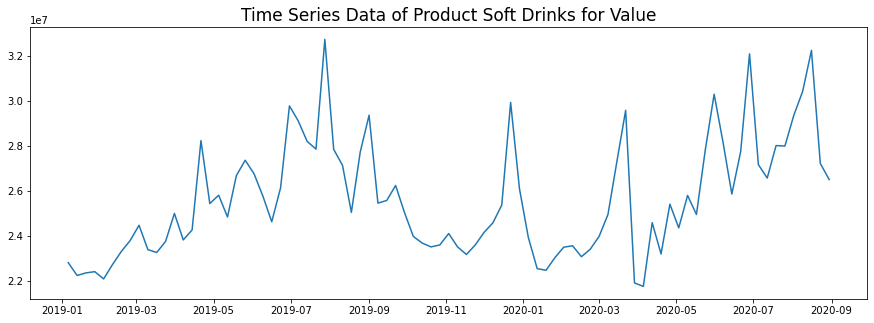

In [20]:
#Plotting the value data for product soft drinks
def plot(data,title):
    plt.figure(figsize=(15,5))
    plt.plot(data)
    plt.title(title,fontsize=17)
    plt.show()
plot(soft_drinks_value,"Time Series Data of Product Soft Drinks for Value")

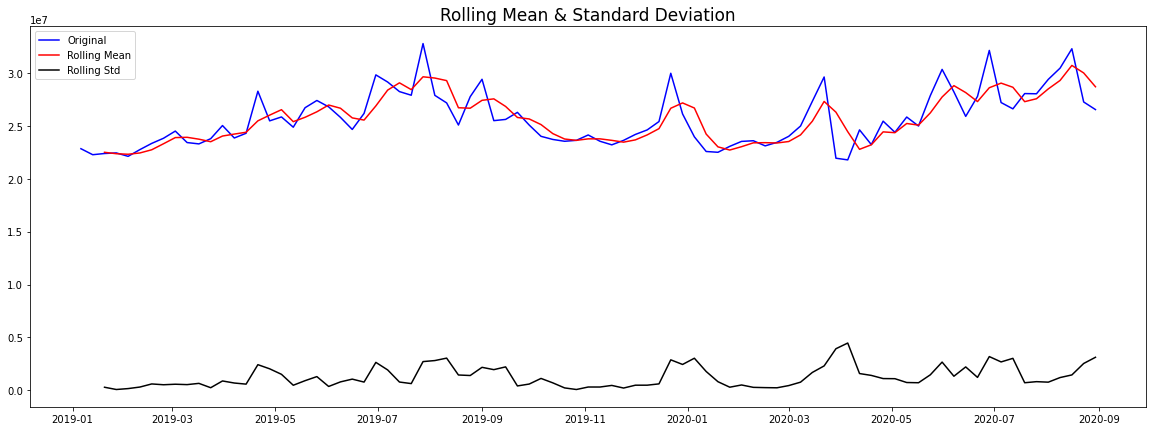

Results of Dickey-Fuller Test:
Test Statistic                 -4.190861
p-value                         0.000683
#Lags Used                      0.000000
Number of Observations Used    86.000000
Critical Value (1%)            -3.508783
Critical Value (5%)            -2.895784
Critical Value (10%)           -2.585038
dtype: float64


In [21]:
#Function for checking the stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(3).mean()
    rolstd = timeseries.rolling(3).std()
    #Plot rolling statistics:
    plt.figure(figsize=(20,7))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation',fontsize=17)
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(soft_drinks_value)

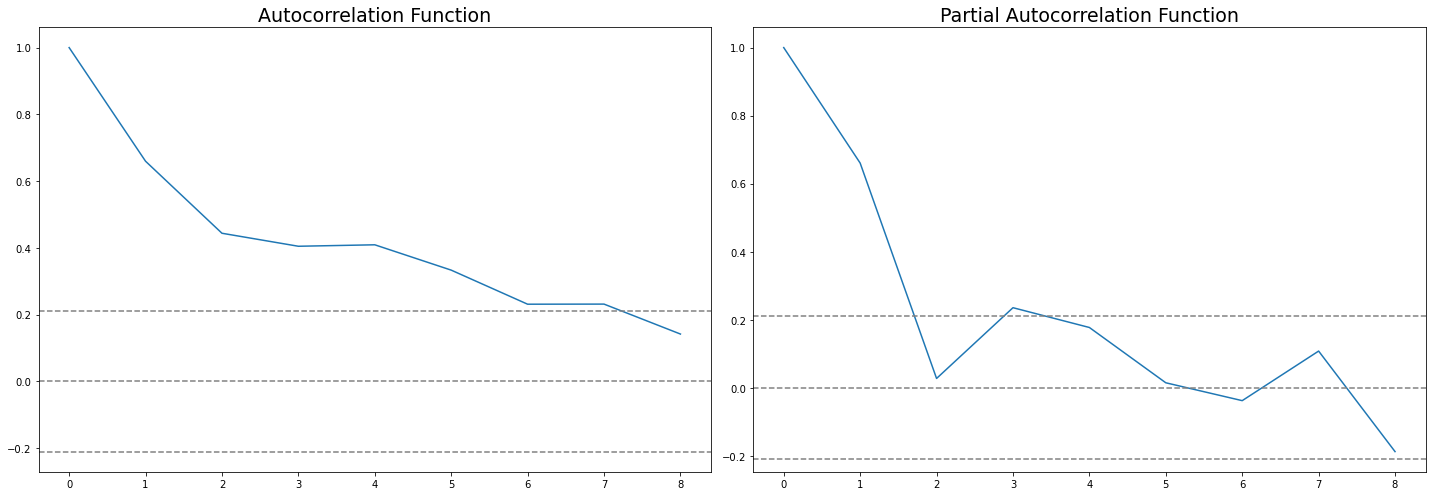

In [22]:
#plotting the autocorrelation and partial autocorrelation for choosing the values of p,q and d
def corr(data):
    lag_acf = acf(data,nlags=8)
    lag_pacf = pacf(data,nlags=8,method='ols')
    plt.figure(figsize=(20,7))

    #plot ACF
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='gray')
    plt.title("Autocorrelation Function",fontsize=19)

    #plot PACF
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='gray')
    plt.title("Partial Autocorrelation Function",fontsize=19)
    plt.tight_layout()
corr(soft_drinks_value)

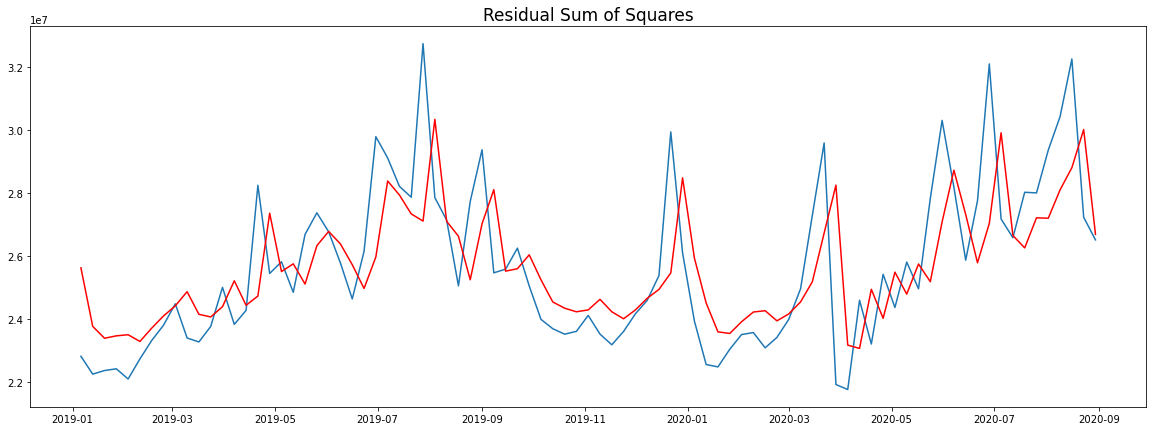

In [23]:
#Plotting the RSS
model = ARIMA(soft_drinks_value,order=(1,0,0))
sdresult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(soft_drinks_value)
plt.plot(sdresult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [24]:
soft_drinks_val_prediction = round(sdresult_ARIMA.predict(1,150),2)
soft_drinks_val_prediction = pd.DataFrame(soft_drinks_val_prediction,columns=['Value']) 
#soft_drinks_val_prediction.to_csv('values_percent_prediction.csv')
soft_drinks_val_prediction.head()

Value
2019-01-13  23770783.14
2019-01-20  23395076.26
2019-01-27  23470997.51
2019-02-03  23507195.12
2019-02-10  23293235.69

In [25]:
soft_drinks = energy2[energy2['Product'] == 'Total Soft Drinks']
soft_drinks_value_per = soft_drinks[['Dates','Value%']]
soft_drinks_value_per = soft_drinks_value_per.set_index('Dates')
soft_drinks_value_per = pd.DataFrame(soft_drinks_value_per['Value%'].resample('W').mean())
soft_drinks_value_per.head()

Value%
Dates                 
2019-01-06  213.222222
2019-01-13  207.923333
2019-01-20  208.994444
2019-01-27  209.501111
2019-02-03  206.485556

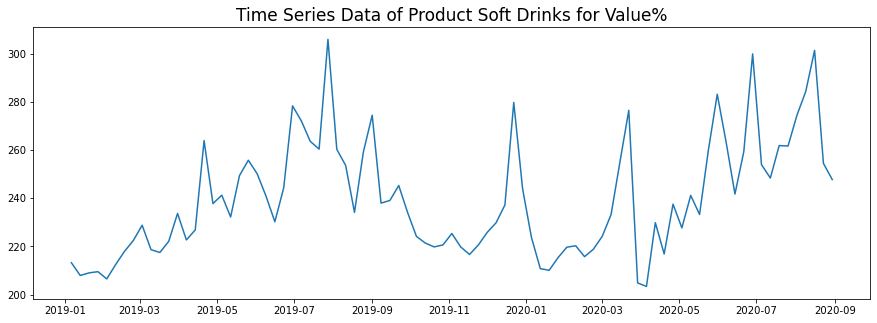

In [26]:
plot(soft_drinks_value_per,"Time Series Data of Product Soft Drinks for Value%")

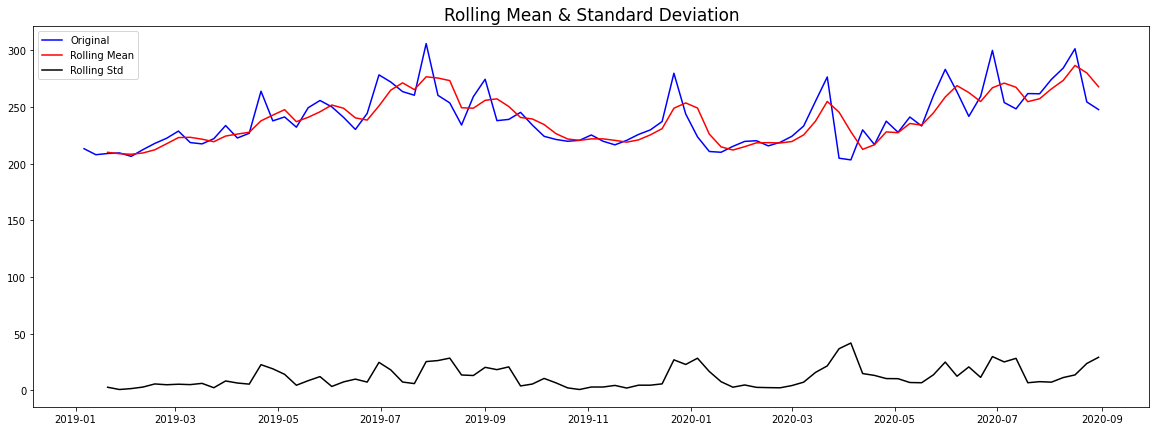

Results of Dickey-Fuller Test:
Test Statistic                 -4.190850
p-value                         0.000683
#Lags Used                      0.000000
Number of Observations Used    86.000000
Critical Value (1%)            -3.508783
Critical Value (5%)            -2.895784
Critical Value (10%)           -2.585038
dtype: float64


In [27]:
test_stationarity(soft_drinks_value_per)

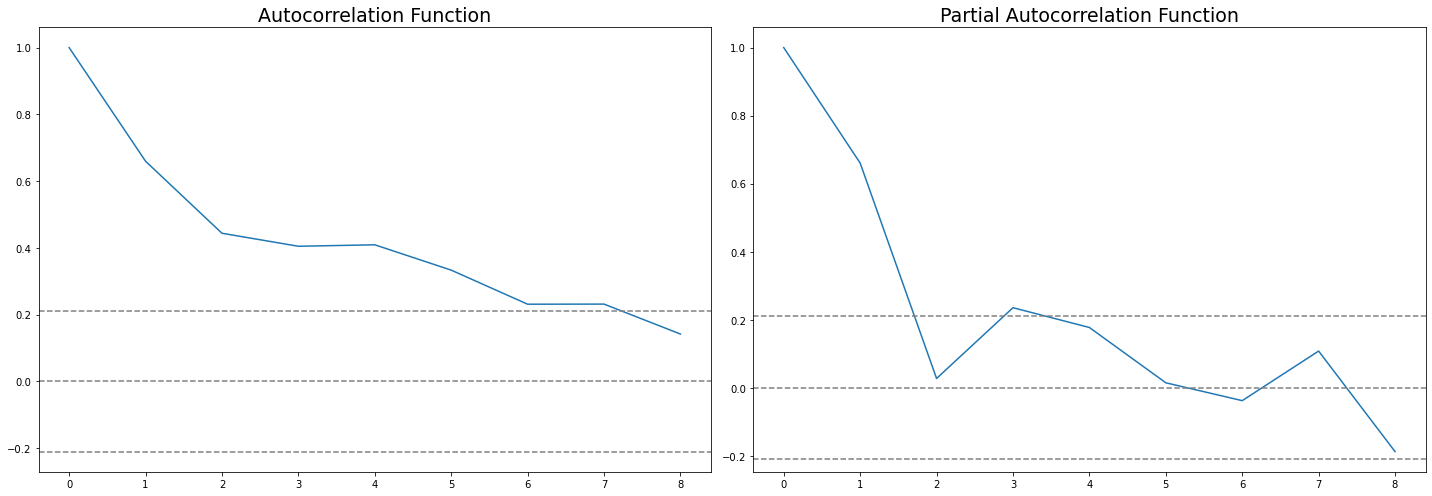

In [28]:
corr(soft_drinks_value_per)

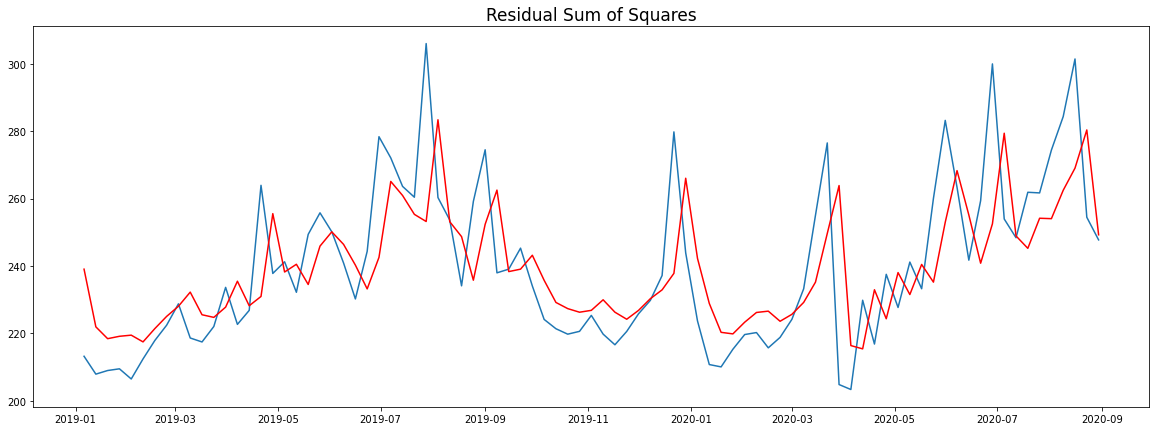

In [29]:
#Plotting the RSS
model = ARIMA(soft_drinks_value_per,order=(1,0,0))
sdpresult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(soft_drinks_value_per)
plt.plot(sdpresult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [30]:
soft_drinks_val_per_prediction = round(sdpresult_ARIMA.predict(1,150),2)
soft_drinks_val_per_prediction = pd.DataFrame(soft_drinks_val_per_prediction,columns=['Value%']) 
soft_drinks_val_per_prediction.head()

Value%
2019-01-13  221.95
2019-01-20  218.44
2019-01-27  219.15
2019-02-03  219.48
2019-02-10  217.48

In [31]:
soft_drinks_lit = soft_drinks[['Dates','Litres']]
soft_drinks_lit = soft_drinks_lit.set_index('Dates')
soft_drinks_lit = pd.DataFrame(soft_drinks_lit['Litres'].resample('W').mean())
soft_drinks_lit.head()

Litres
Dates                   
2019-01-06  2.346602e+07
2019-01-13  2.272625e+07
2019-01-20  2.285198e+07
2019-01-27  2.281962e+07
2019-02-03  2.221009e+07

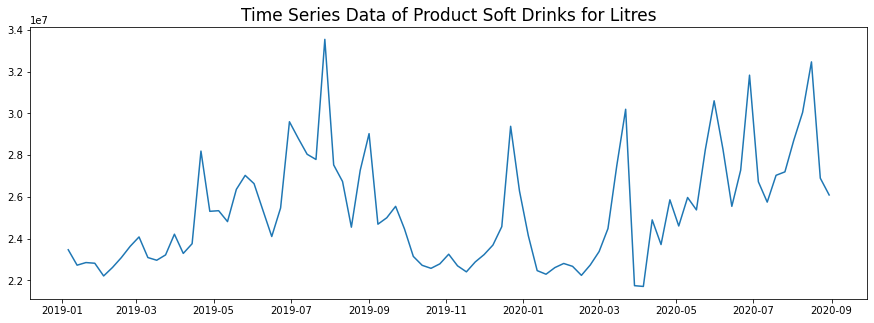

In [32]:
plot(soft_drinks_lit,"Time Series Data of Product Soft Drinks for Litres")

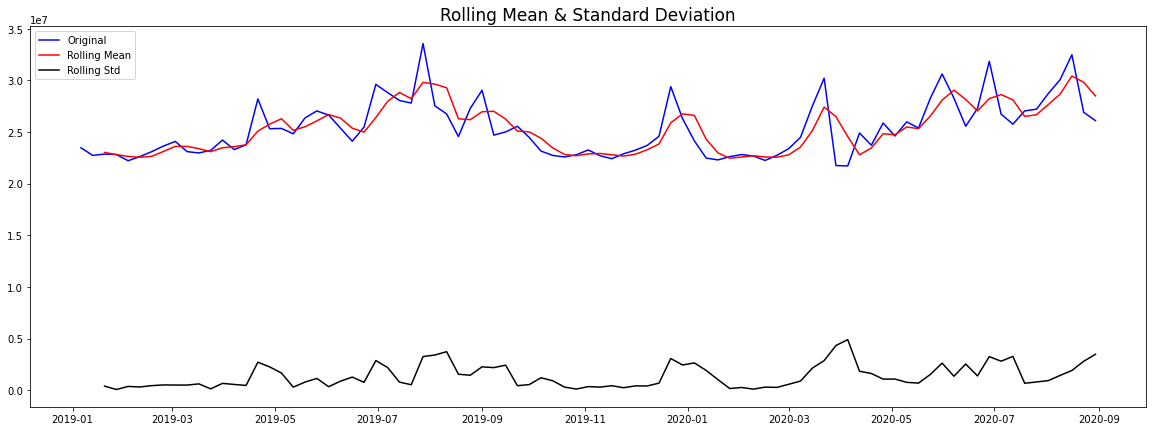

Results of Dickey-Fuller Test:
Test Statistic                 -4.345764
p-value                         0.000370
#Lags Used                      0.000000
Number of Observations Used    86.000000
Critical Value (1%)            -3.508783
Critical Value (5%)            -2.895784
Critical Value (10%)           -2.585038
dtype: float64


In [33]:
test_stationarity(soft_drinks_lit)

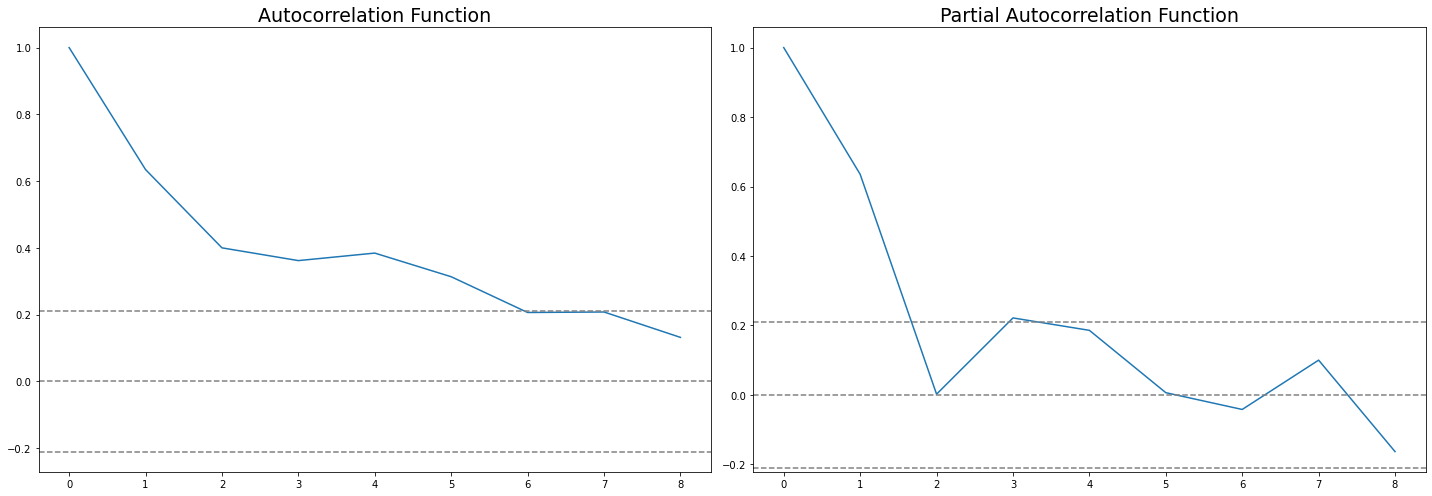

In [34]:
corr(soft_drinks_lit)

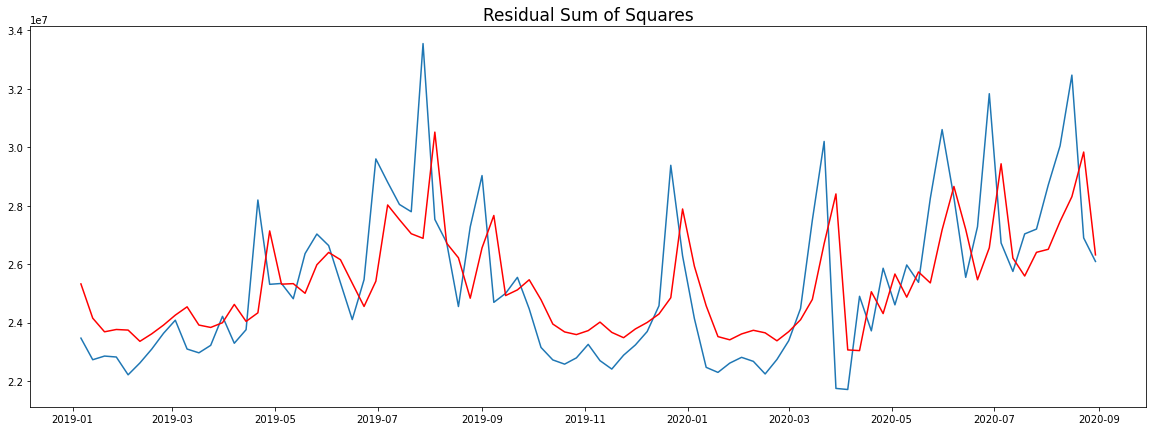

In [35]:
#Plotting the RSS
model = ARIMA(soft_drinks_lit,order=(1,0,0))
sdlresult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(soft_drinks_lit)
plt.plot(sdlresult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [36]:
soft_drinks_lit_prediction = round(sdlresult_ARIMA.predict(1,150),2)
soft_drinks_lit_prediction = pd.DataFrame(soft_drinks_lit_prediction,columns=['Litres']) 
soft_drinks_lit_prediction.head()

Litres
2019-01-13  24149790.56
2019-01-20  23682533.87
2019-01-27  23761942.61
2019-02-03  23741505.82
2019-02-10  23356512.93

In [37]:
soft_drinks_lit_per = soft_drinks[['Dates','Litres%']]
soft_drinks_lit_per = soft_drinks_lit_per.set_index('Dates')
soft_drinks_lit_per = pd.DataFrame(soft_drinks_lit_per['Litres%'].resample('W').mean())
soft_drinks_lit_per.head()

Litres%
Dates                 
2019-01-06  290.271111
2019-01-13  281.120000
2019-01-20  282.675556
2019-01-27  282.273333
2019-02-03  274.733333

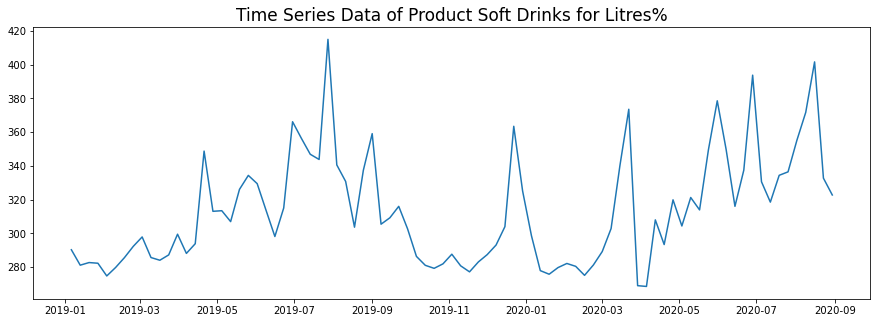

In [38]:
plot(soft_drinks_lit_per,"Time Series Data of Product Soft Drinks for Litres%")

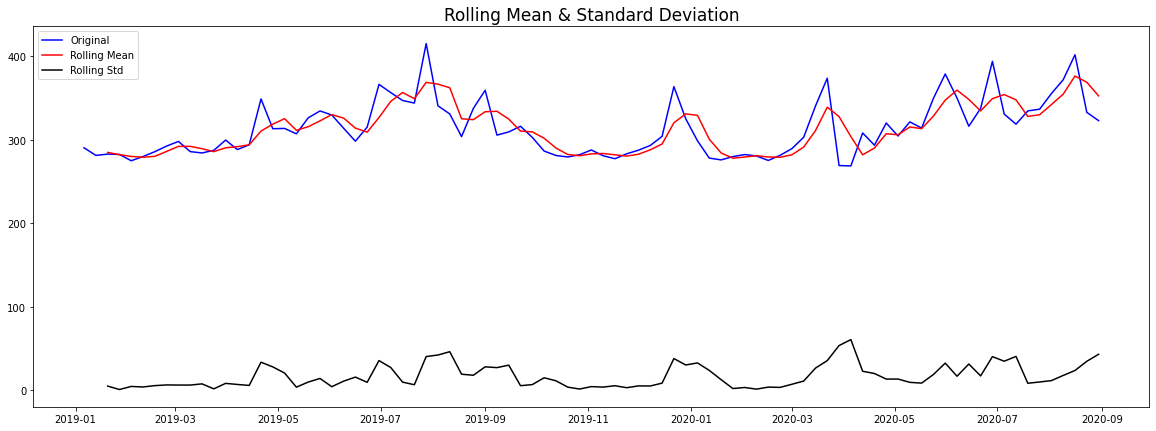

Results of Dickey-Fuller Test:
Test Statistic                 -4.345779
p-value                         0.000370
#Lags Used                      0.000000
Number of Observations Used    86.000000
Critical Value (1%)            -3.508783
Critical Value (5%)            -2.895784
Critical Value (10%)           -2.585038
dtype: float64


In [39]:
test_stationarity(soft_drinks_lit_per)

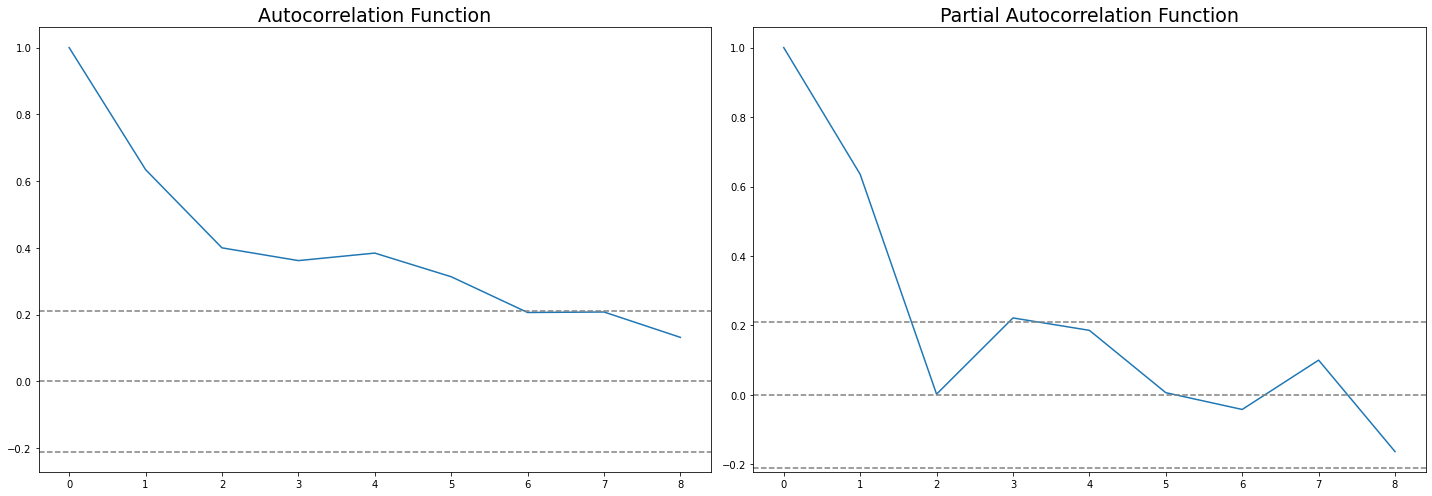

In [40]:
corr(soft_drinks_lit_per)

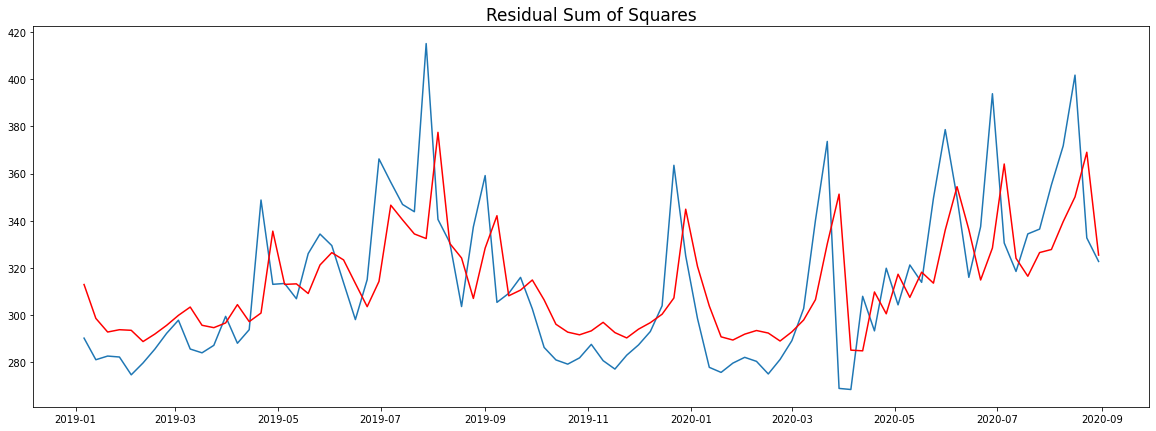

In [41]:
#Plotting the RSS
model = ARIMA(soft_drinks_lit_per,order=(1,0,0))
sdlpresult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(soft_drinks_lit_per)
plt.plot(sdlpresult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [42]:
soft_drinks_lit_per_prediction = round(sdlpresult_ARIMA.predict(1,150),2)
soft_drinks_lit_per_prediction = pd.DataFrame(soft_drinks_lit_per_prediction,columns=['Litres%']) 
soft_drinks_lit_per_prediction.head()

Litres%
2019-01-13   298.63
2019-01-20   292.85
2019-01-27   293.84
2019-02-03   293.58
2019-02-10   288.82

In [43]:
soft_drinks = pd.concat([soft_drinks_value,soft_drinks_value_per,soft_drinks_lit,soft_drinks_lit_per],axis=1)
soft_drinks['product'] = 'Total Soft Drinks'

# Time Series Forecasting For Product Lucozade Everyday Energy 3

In [44]:
Lucozade = energy2[energy2['Product'] == 'Lucozade Everyday Energy 3']
Lucozade_value = Lucozade[['Dates','Value']]
Lucozade_value = Lucozade_value.set_index('Dates')
Lucozade_value= pd.DataFrame(Lucozade_value.Value.resample('W').mean())
Lucozade_value.head()

Value
Dates                  
2019-01-06  792355.5450
2019-01-13  845350.0350
2019-01-20  846848.1200
2019-01-27  864152.6675
2019-02-03  840236.6150

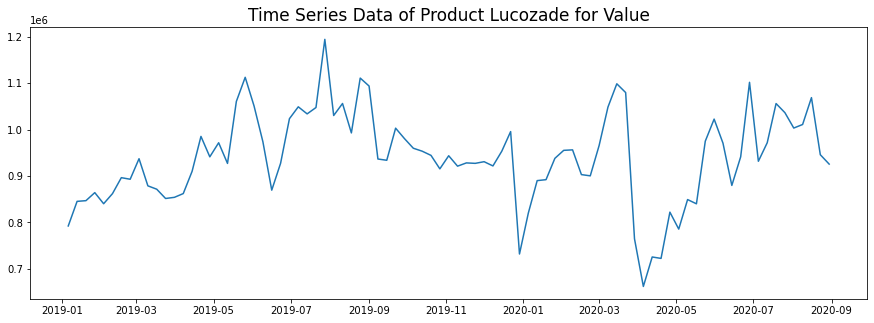

In [45]:
plot(Lucozade_value,"Time Series Data of Product Lucozade for Value")

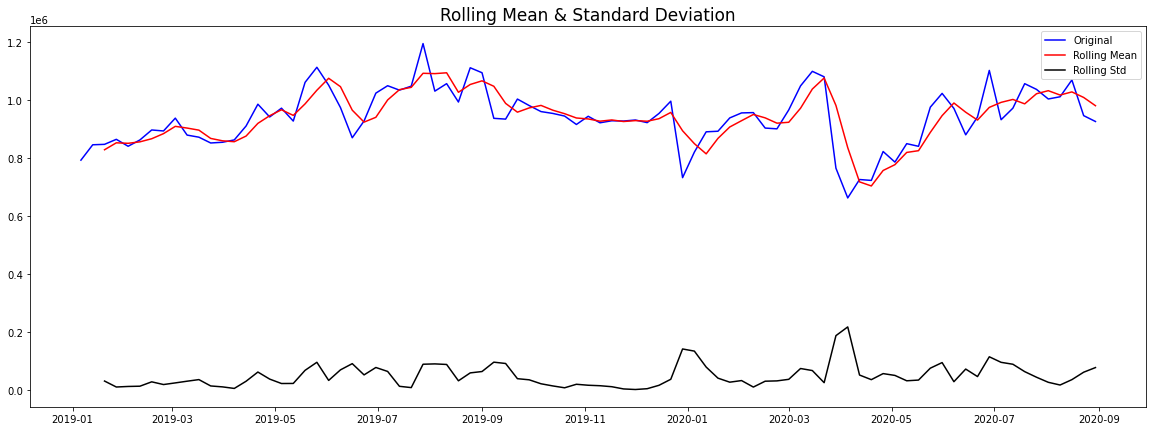

Results of Dickey-Fuller Test:
Test Statistic                 -4.221447
p-value                         0.000606
#Lags Used                      0.000000
Number of Observations Used    86.000000
Critical Value (1%)            -3.508783
Critical Value (5%)            -2.895784
Critical Value (10%)           -2.585038
dtype: float64


In [46]:
test_stationarity(Lucozade_value)

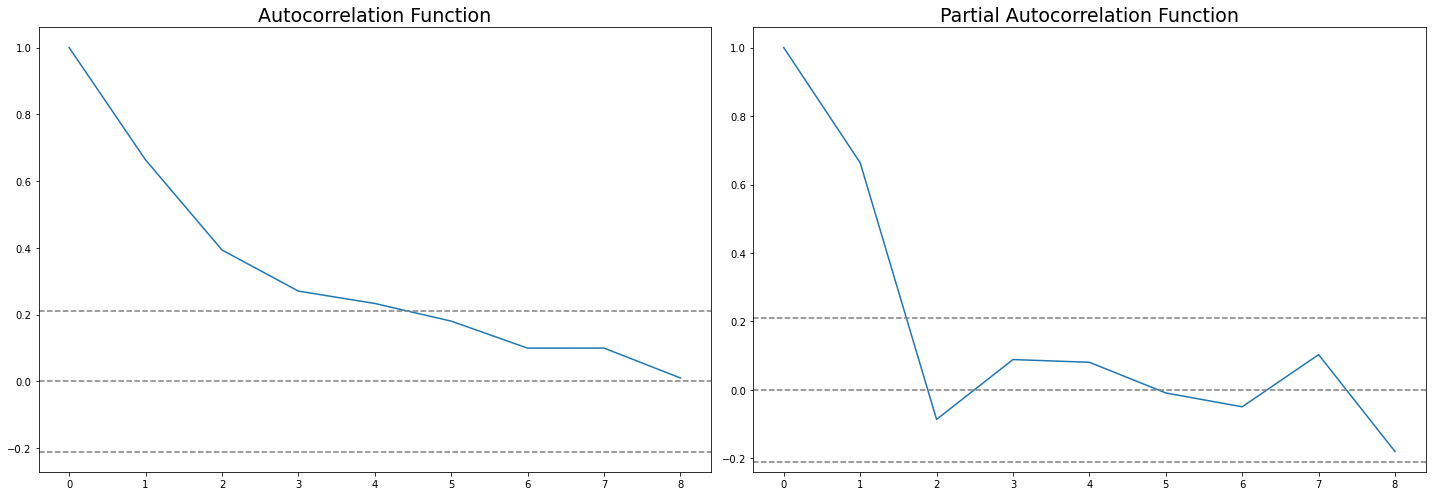

In [47]:
corr(Lucozade_value)

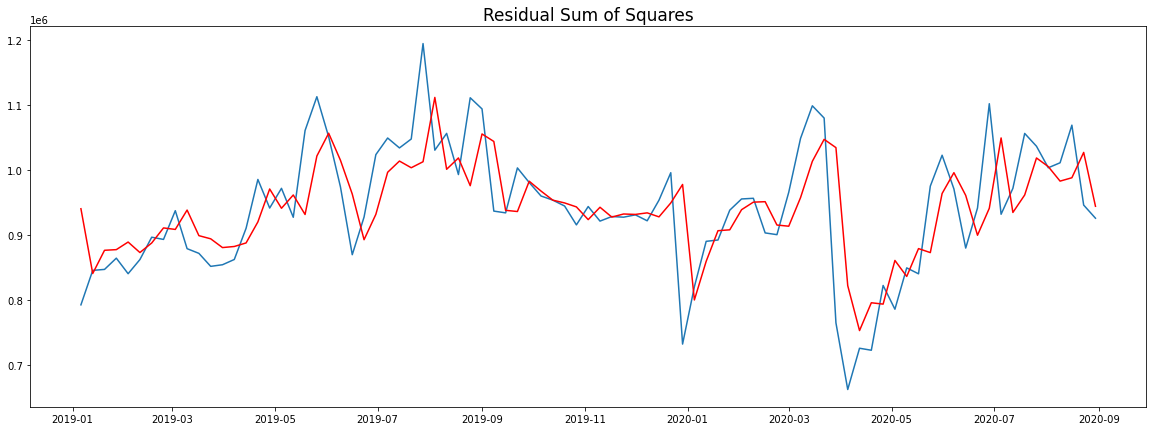

In [48]:
#Plotting the RSS
model = ARIMA(Lucozade_value,order=(1,0,0))
Lzresult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(Lucozade_value)
plt.plot(Lzresult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [49]:
Lucozade_val_prediction = round(Lzresult_ARIMA.predict(1,150),2)
Lucozade_val_prediction = pd.DataFrame(Lucozade_val_prediction,columns=['Value']) 
Lucozade_val_prediction.head()

Value
2019-01-13  840546.42
2019-01-20  876263.89
2019-01-27  877273.57
2019-02-03  888936.57
2019-02-10  872817.52

In [50]:
Lucozade_value_per = Lucozade[['Dates','Value%']]
Lucozade_value_per = Lucozade_value_per.set_index('Dates')
Lucozade_value_per = pd.DataFrame(Lucozade_value_per['Value%'].resample('W').mean())
Lucozade_value_per.head()

Value%
Dates              
2019-01-06  7.40125
2019-01-13  7.89750
2019-01-20  7.91125
2019-01-27  8.07250
2019-02-03  7.84875

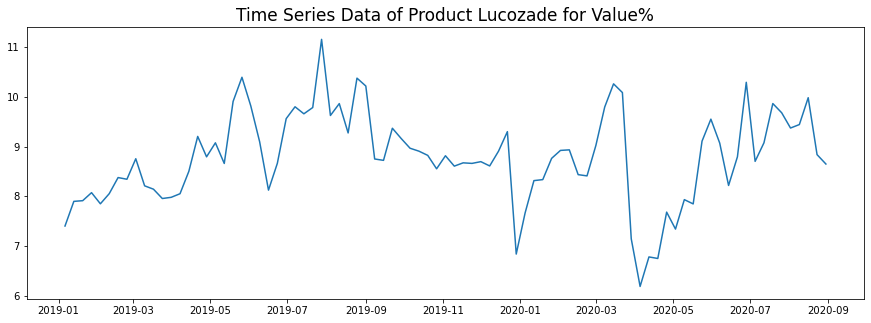

In [51]:
plot(Lucozade_value_per,"Time Series Data of Product Lucozade for Value%")

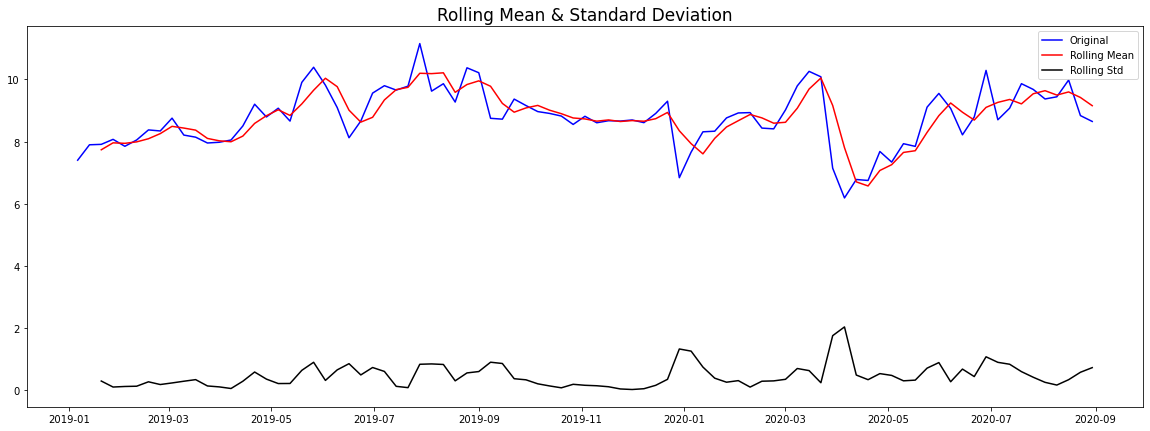

Results of Dickey-Fuller Test:
Test Statistic                 -4.221981
p-value                         0.000605
#Lags Used                      0.000000
Number of Observations Used    86.000000
Critical Value (1%)            -3.508783
Critical Value (5%)            -2.895784
Critical Value (10%)           -2.585038
dtype: float64


In [52]:
test_stationarity(Lucozade_value_per)

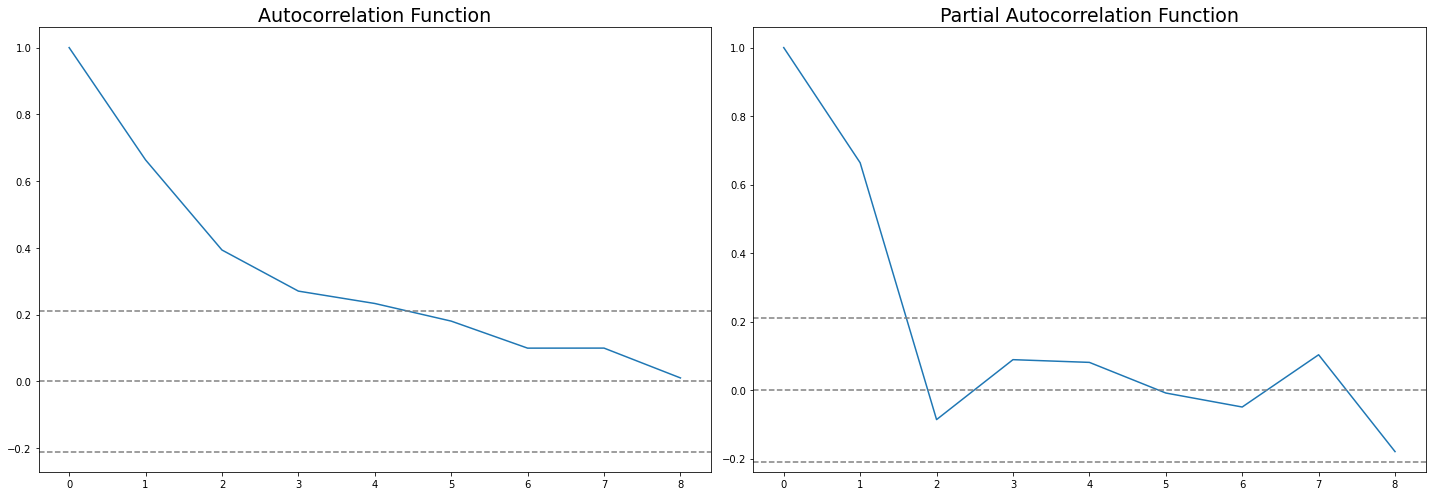

In [53]:
corr(Lucozade_value_per)

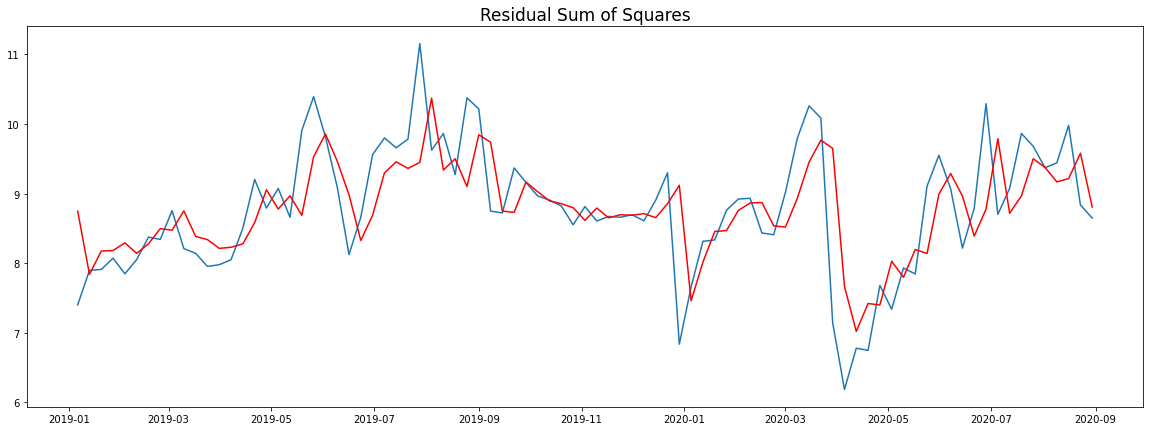

In [54]:
#Plotting the RSS
model = ARIMA(Lucozade_value_per,order=(1,0,0))
Lzpresult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(Lucozade_value_per)
plt.plot(Lzpresult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [55]:
Lucozade_val_per_prediction = round(Lzpresult_ARIMA.predict(1,150),2)
Lucozade_val_per_prediction = pd.DataFrame(Lucozade_val_per_prediction,columns=['Value%']) 
Lucozade_val_per_prediction.head()

Value%
2019-01-13    7.84
2019-01-20    8.17
2019-01-27    8.18
2019-02-03    8.29
2019-02-10    8.14

In [56]:
Lucozade_lit = Lucozade[['Dates','Litres']]
Lucozade_lit = Lucozade_lit.set_index('Dates')
Lucozade_lit = pd.DataFrame(Lucozade_lit['Litres'].resample('W').mean())
Lucozade_lit.head()

Litres
Dates                  
2019-01-06  615024.3600
2019-01-13  638812.7775
2019-01-20  657206.8900
2019-01-27  684825.8300
2019-02-03  649773.8000

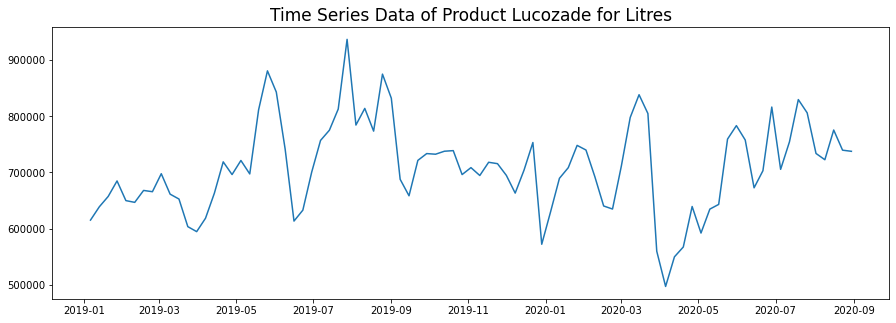

In [57]:
plot(Lucozade_lit,"Time Series Data of Product Lucozade for Litres")

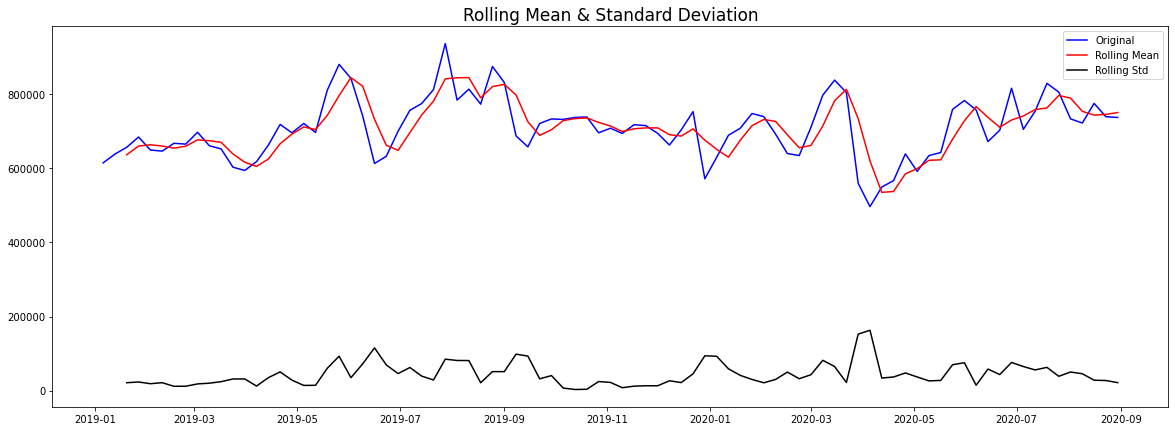

Results of Dickey-Fuller Test:
Test Statistic                 -4.727834
p-value                         0.000075
#Lags Used                      1.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


In [58]:
test_stationarity(Lucozade_lit)

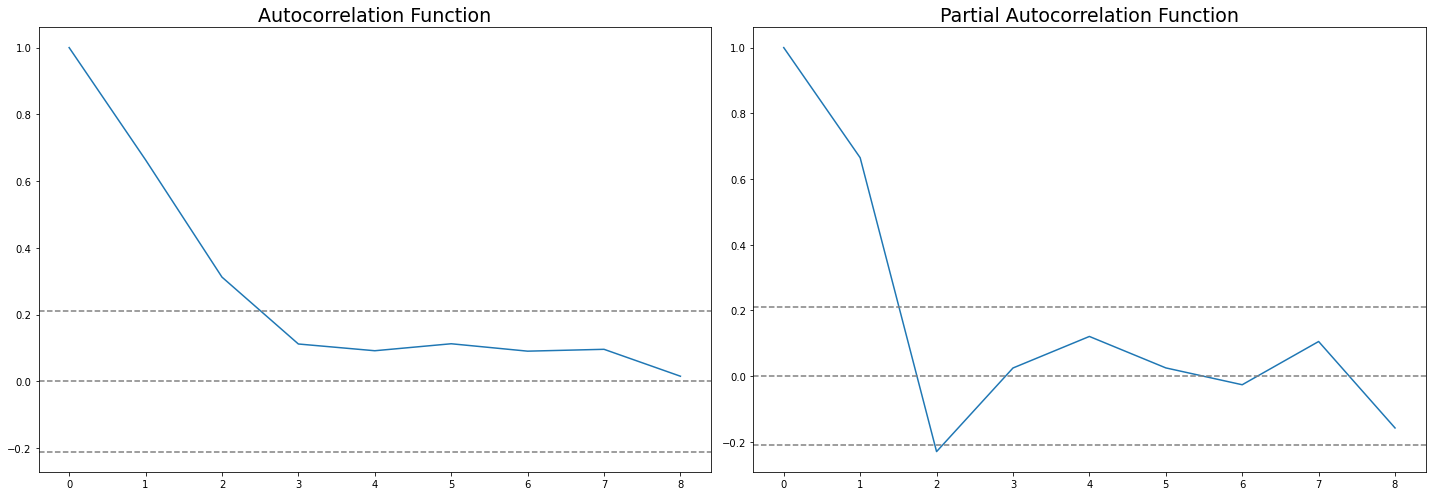

In [59]:
corr(Lucozade_lit)

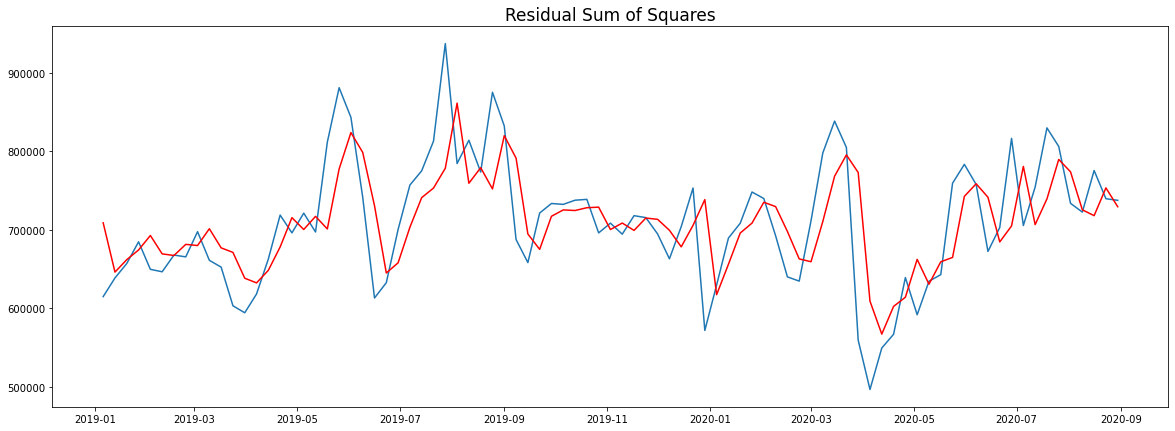

In [60]:
#Plotting the RSS
model = ARIMA(Lucozade_lit,order=(1,0,0))
Lzlresult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(Lucozade_lit)
plt.plot(Lzlresult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [61]:
Lucozade_lit_prediction = round(Lzlresult_ARIMA.predict(1,150),2)
Lucozade_lit_prediction = pd.DataFrame(Lucozade_lit_prediction,columns=['Litres']) 
Lucozade_lit_prediction.head()

Litres
2019-01-13  646258.49
2019-01-20  662141.68
2019-01-27  674423.16
2019-02-03  692863.92
2019-02-10  669460.19

In [62]:
Lucozade_lit_per = Lucozade[['Dates','Litres%']]
Lucozade_lit_per = Lucozade_lit_per.set_index('Dates')
Lucozade_lit_per = pd.DataFrame(Lucozade_lit_per['Litres%'].resample('W').mean())
Lucozade_lit_per.head()

Litres%
Dates              
2019-01-06  7.60625
2019-01-13  7.90125
2019-01-20  8.12750
2019-01-27  8.47250
2019-02-03  8.04000

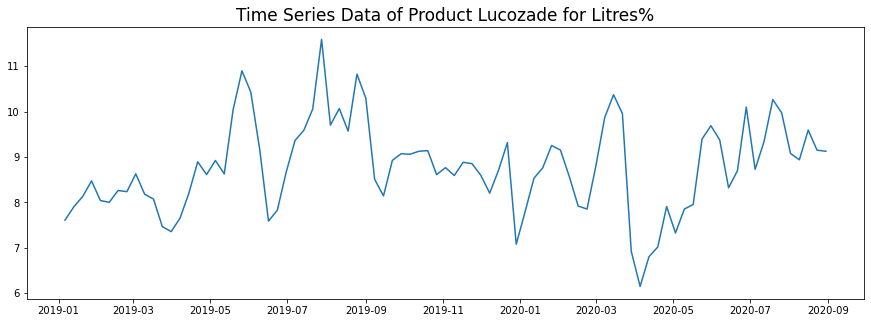

In [63]:
plot(Lucozade_lit_per,"Time Series Data of Product Lucozade for Litres%")

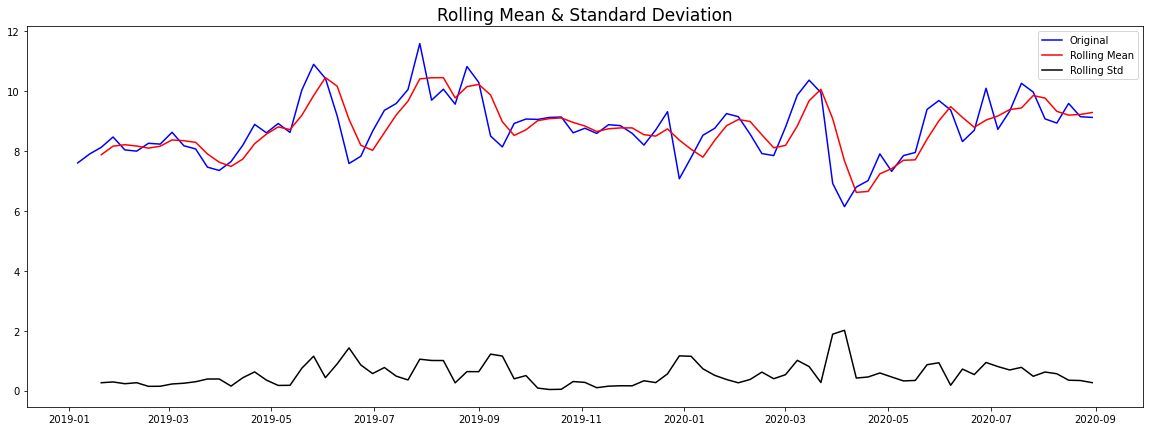

Results of Dickey-Fuller Test:
Test Statistic                 -4.729050
p-value                         0.000074
#Lags Used                      1.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


In [64]:
test_stationarity(Lucozade_lit_per)

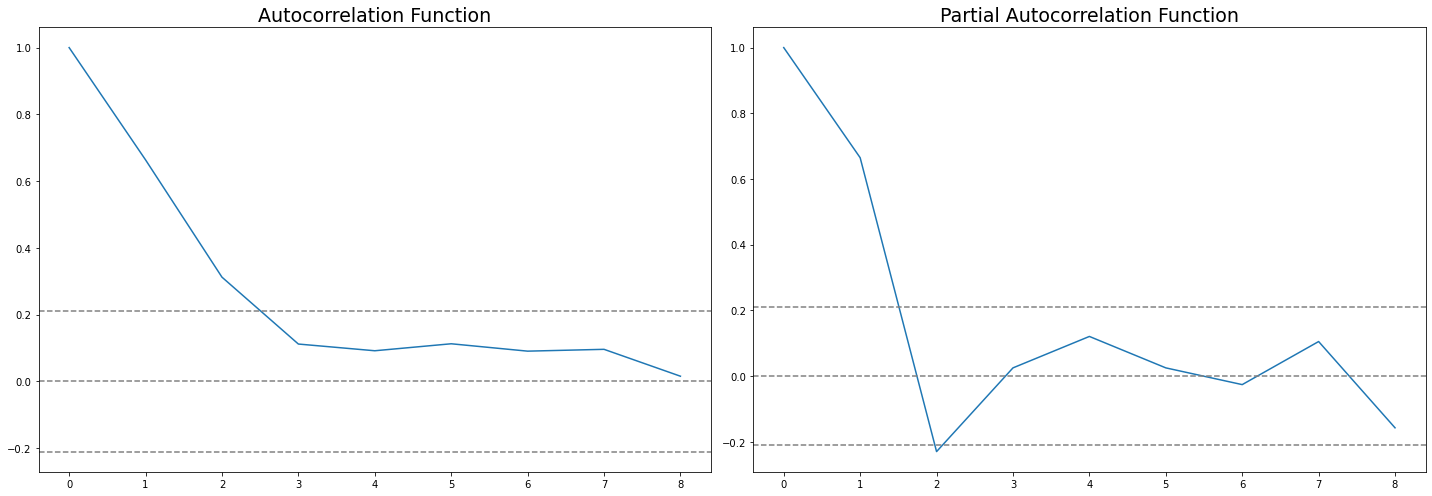

In [65]:
corr(Lucozade_lit_per)

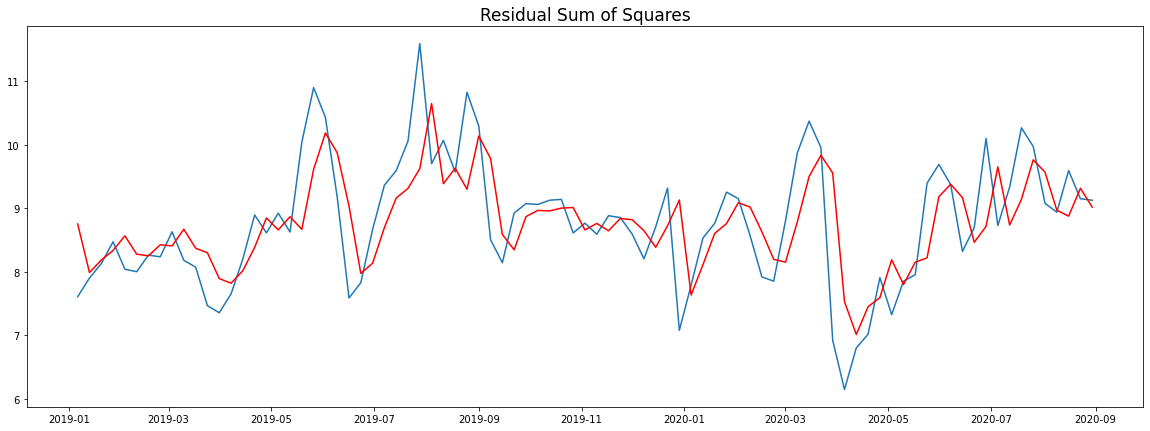

In [66]:
#Plotting the RSS
model = ARIMA(Lucozade_lit_per,order=(1,0,0))
Lzlpresult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(Lucozade_lit_per)
plt.plot(Lzlpresult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [67]:
Lucozade_lit_per_prediction = round(Lzlpresult_ARIMA.predict(1,150),2)
Lucozade_lit_per_prediction = pd.DataFrame(Lucozade_lit_per_prediction,columns=['Litres%']) 
Lucozade_lit_per_prediction.head()

Litres%
2019-01-13     7.99
2019-01-20     8.18
2019-01-27     8.34
2019-02-03     8.57
2019-02-10     8.28

In [68]:
Lucozade = pd.concat([Lucozade_value,Lucozade_value_per,Lucozade_lit,Lucozade_lit_per],axis=1)
Lucozade['product'] = 'Lucozade Everyday Energy 3'

# Time series Forecasting for Everyday Energy 2

In [69]:
everyday = energy2[energy2['Product'] == 'Everyday Energy 2']
everyday_value = everyday[['Dates','Value']]
everyday_value = everyday_value.set_index('Dates')
everyday_value= pd.DataFrame(everyday_value.Value.resample('W').mean())
everyday_value.head()

Value
Dates                  
2019-01-06  863896.5600
2019-01-13  913940.8525
2019-01-20  916290.5625
2019-01-27  934868.8600
2019-02-03  909504.2475

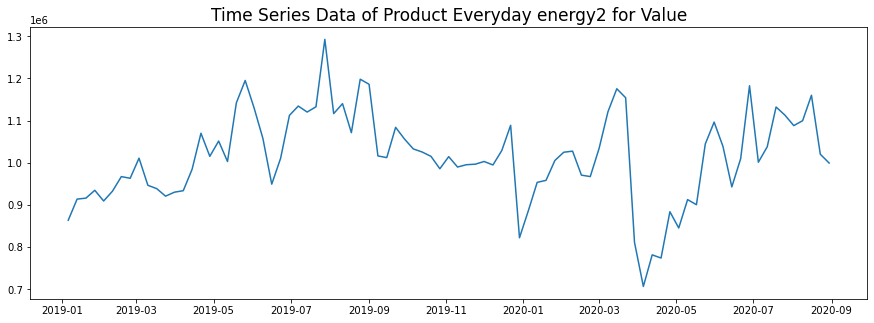

In [70]:
plot(everyday_value,"Time Series Data of Product Everyday energy2 for Value")

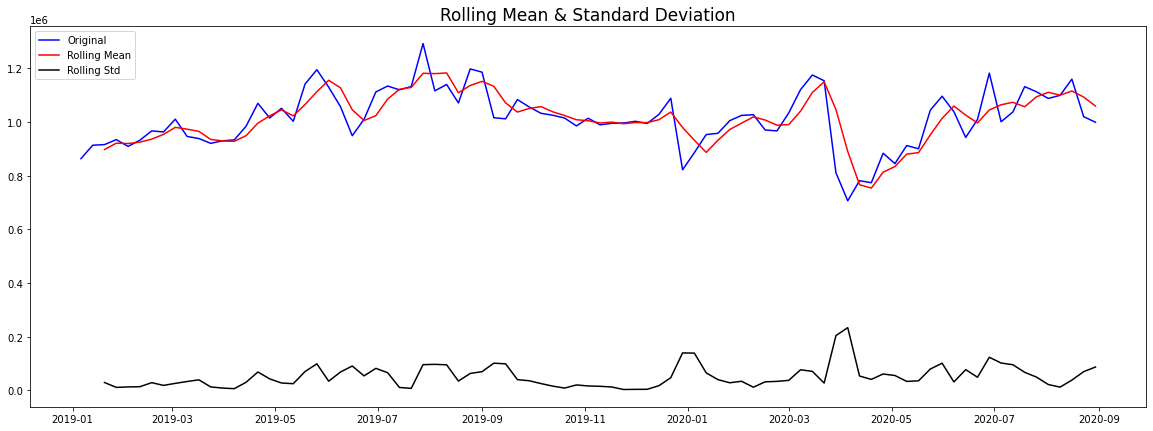

Results of Dickey-Fuller Test:
Test Statistic                 -4.141260
p-value                         0.000827
#Lags Used                      0.000000
Number of Observations Used    86.000000
Critical Value (1%)            -3.508783
Critical Value (5%)            -2.895784
Critical Value (10%)           -2.585038
dtype: float64


In [71]:
test_stationarity(everyday_value)

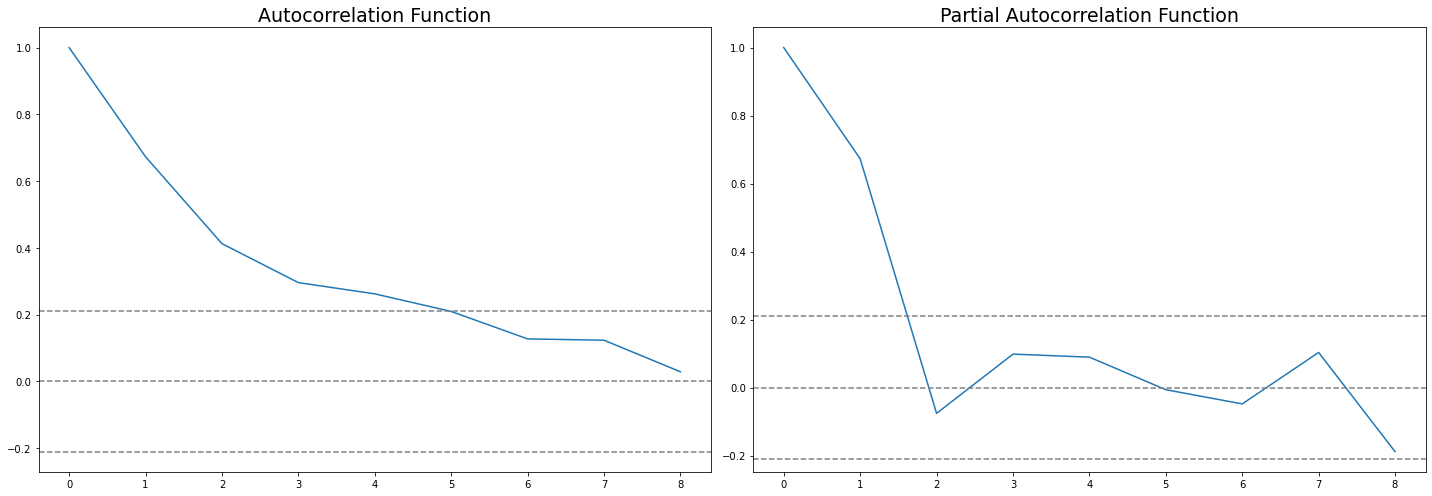

In [72]:
corr(everyday_value)

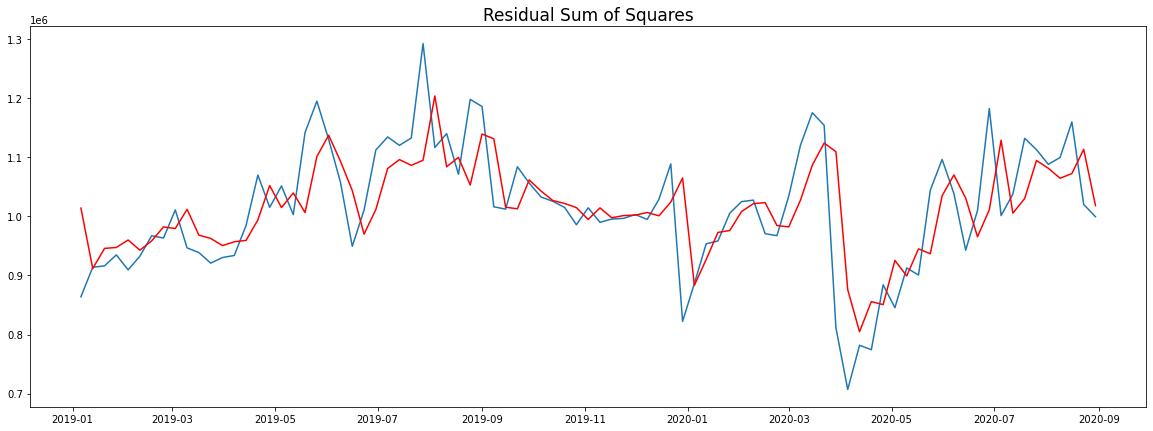

In [73]:
#Plotting the RSS
model = ARIMA(everyday_value,order=(1,0,0))
edresult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(everyday_value)
plt.plot(edresult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [74]:
everyday_val_prediction = round(edresult_ARIMA.predict(1,150),2)
everyday_val_prediction = pd.DataFrame(everyday_val_prediction,columns=['Value']) 
everyday_val_prediction.head()

Value
2019-01-13  911742.00
2019-01-20  945851.53
2019-01-27  947453.06
2019-02-03  960115.79
2019-02-10  942827.60

In [75]:
everyday_value_per = everyday[['Dates','Value%']]
everyday_value_per = everyday_value_per.set_index('Dates')
everyday_value_per= pd.DataFrame(everyday_value_per['Value%'].resample('W').mean())
everyday_value_per.head()

Value%
Dates              
2019-01-06  8.07125
2019-01-13  8.53750
2019-01-20  8.56000
2019-01-27  8.73625
2019-02-03  8.49750

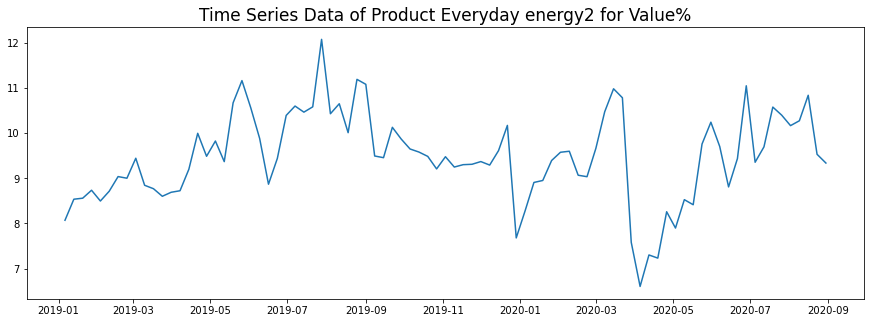

In [76]:
plot(everyday_value_per,"Time Series Data of Product Everyday energy2 for Value%")

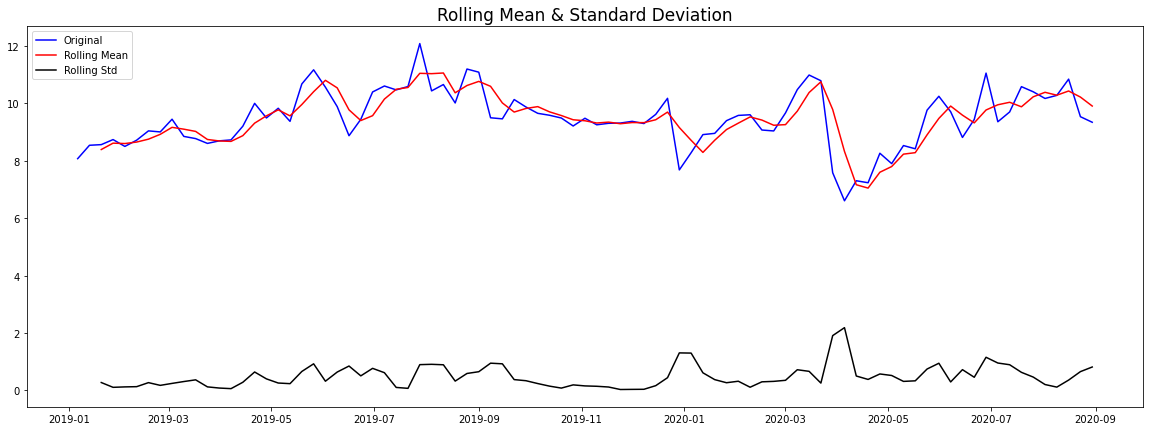

Results of Dickey-Fuller Test:
Test Statistic                 -4.141418
p-value                         0.000827
#Lags Used                      0.000000
Number of Observations Used    86.000000
Critical Value (1%)            -3.508783
Critical Value (5%)            -2.895784
Critical Value (10%)           -2.585038
dtype: float64


In [77]:
test_stationarity(everyday_value_per)

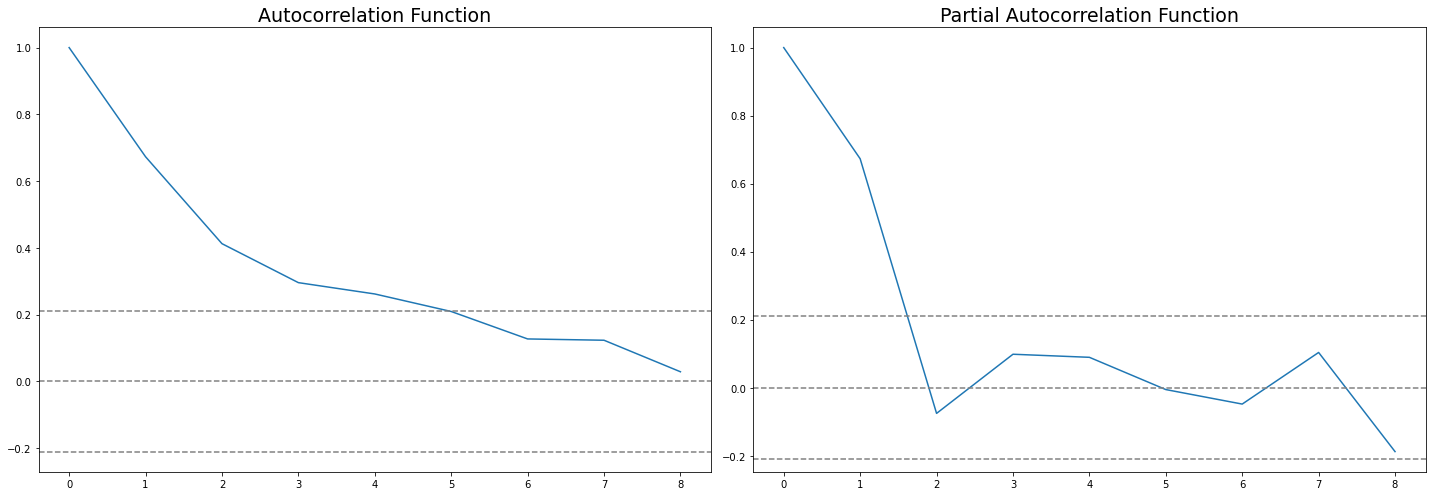

In [78]:
corr(everyday_value_per)

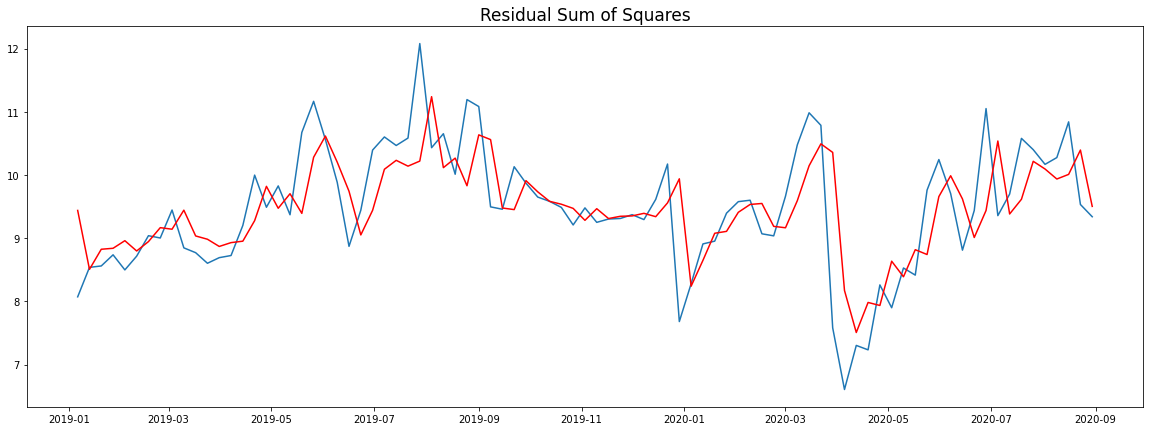

In [79]:
#Plotting the RSS
model = ARIMA(everyday_value_per,order=(1,0,0))
edpresult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(everyday_value_per)
plt.plot(edpresult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [80]:
everyday_val_per_prediction = round(edpresult_ARIMA.predict(1,150),2)
everyday_val_per_prediction = pd.DataFrame(everyday_val_per_prediction,columns=['Value%']) 
everyday_val_per_prediction.head()

Value%
2019-01-13    8.51
2019-01-20    8.82
2019-01-27    8.84
2019-02-03    8.96
2019-02-10    8.80

In [81]:
everyday_lit = everyday[['Dates','Litres']]
everyday_lit = everyday_lit.set_index('Dates')
everyday_lit = pd.DataFrame(everyday_lit['Litres'].resample('W').mean())
everyday_lit.head()

Litres
Dates                   
2019-01-06  643464.74500
2019-01-13  664857.70125
2019-01-20  683752.10000
2019-01-27  712077.28500
2019-02-03  676234.39125

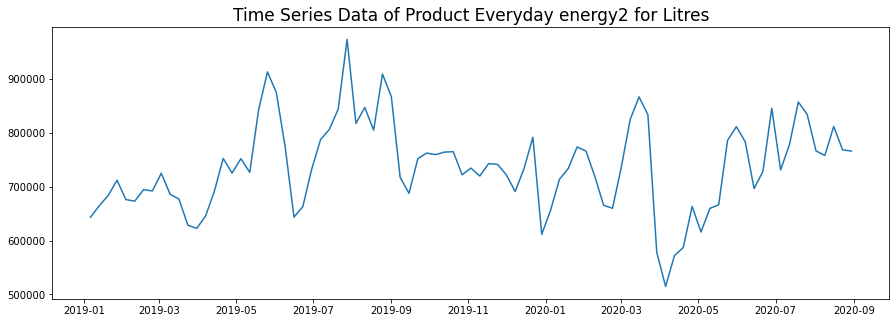

In [82]:
plot(everyday_lit,"Time Series Data of Product Everyday energy2 for Litres")

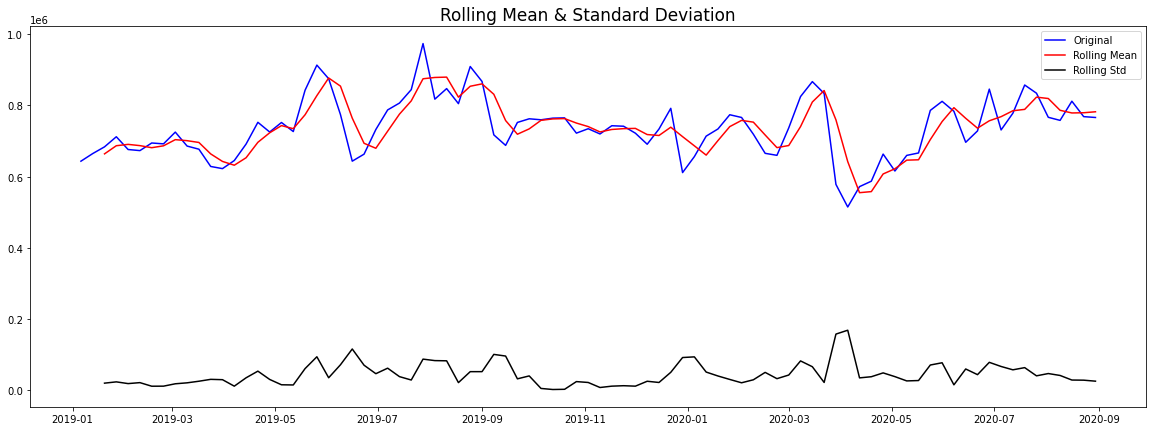

Results of Dickey-Fuller Test:
Test Statistic                 -4.653547
p-value                         0.000103
#Lags Used                      1.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


In [83]:
test_stationarity(everyday_lit)

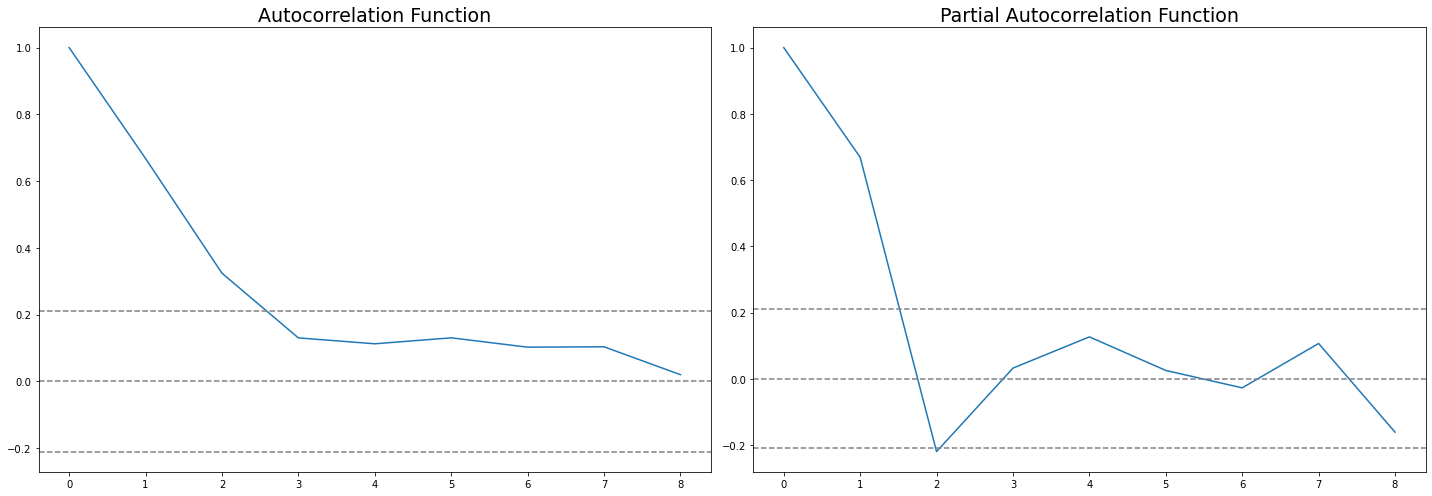

In [84]:
corr(everyday_lit)

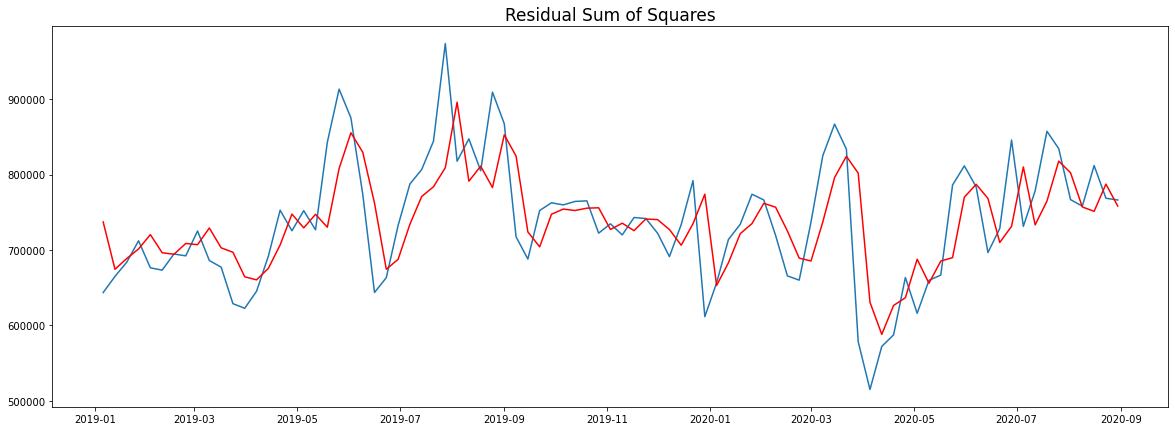

In [85]:
#Plotting the RSS
model = ARIMA(everyday_lit,order=(1,0,0))
edlresult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(everyday_lit)
plt.plot(edlresult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [86]:
everyday_lit_prediction = round(edlresult_ARIMA.predict(1,150),2)
everyday_lit_prediction = pd.DataFrame(everyday_lit_prediction,columns=['Litres']) 
everyday_lit_prediction.head()

Litres
2019-01-13  674278.96
2019-01-20  688635.38
2019-01-27  701315.06
2019-02-03  720323.57
2019-02-10  696270.06

In [87]:
everyday_lit_per = everyday[['Dates','Litres%']]
everyday_lit_per = everyday_lit_per.set_index('Dates')
everyday_lit_per = pd.DataFrame(everyday_lit_per['Litres%'].resample('W').mean())
everyday_lit_per.head()

Litres%
Dates              
2019-01-06  7.95875
2019-01-13  8.22250
2019-01-20  8.45750
2019-01-27  8.80750
2019-02-03  8.36375

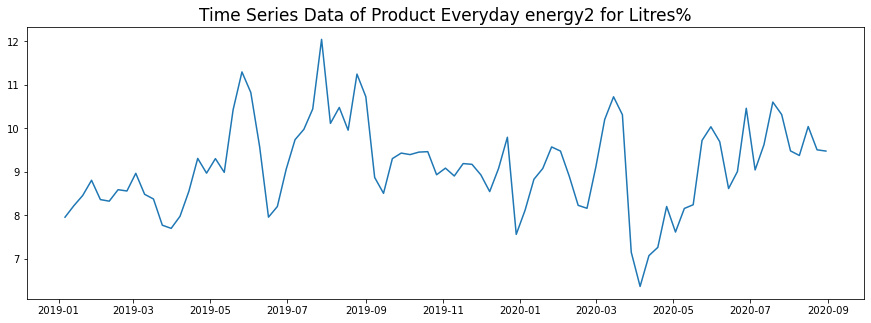

In [88]:
plot(everyday_lit_per,"Time Series Data of Product Everyday energy2 for Litres%")

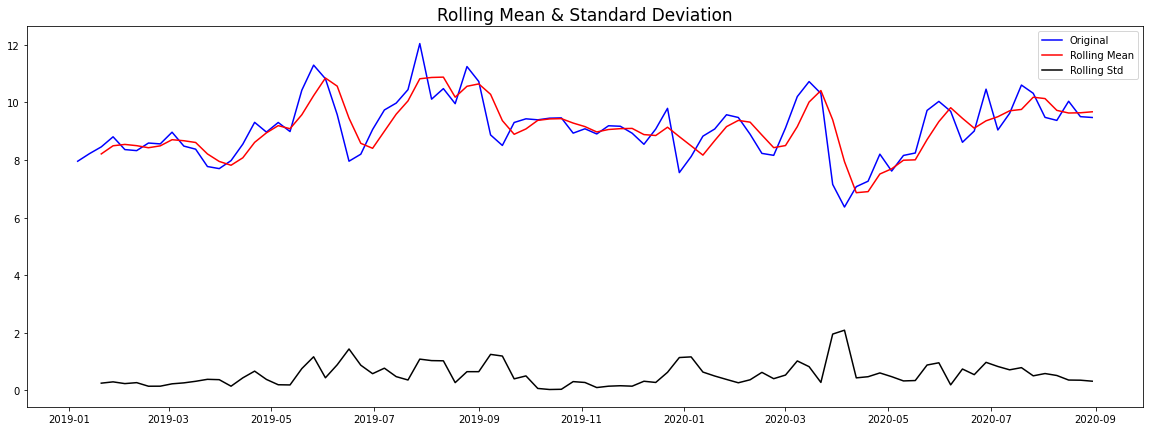

Results of Dickey-Fuller Test:
Test Statistic                 -4.654345
p-value                         0.000102
#Lags Used                      1.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


In [89]:
test_stationarity(everyday_lit_per)

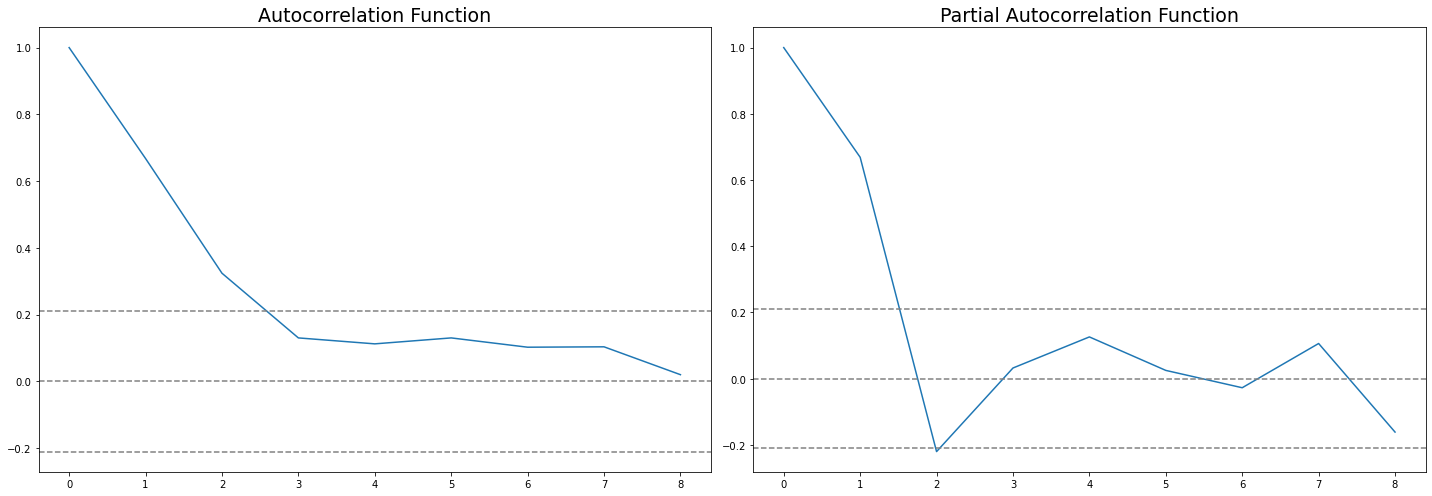

In [90]:
corr(everyday_lit_per)

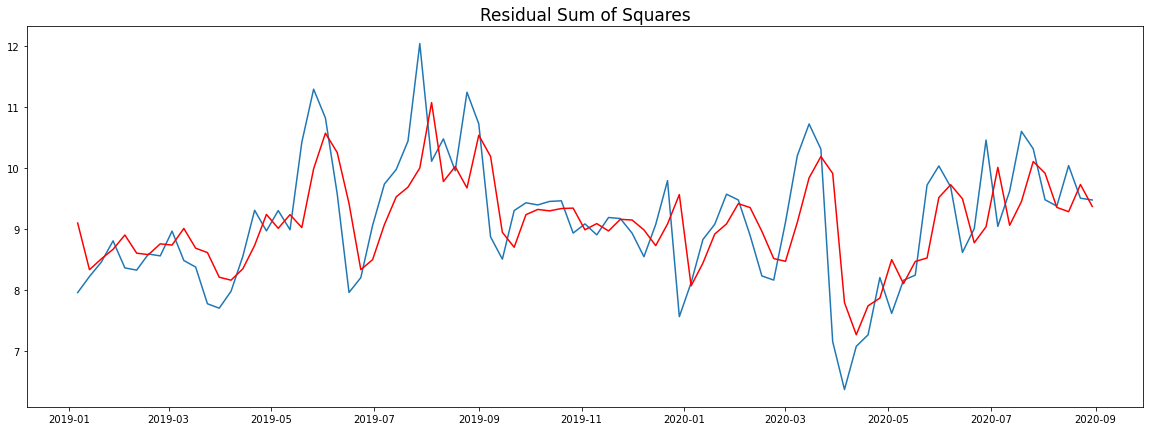

In [91]:
#Plotting the RSS
model = ARIMA(everyday_lit_per,order=(1,0,0))
edlpresult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(everyday_lit_per)
plt.plot(edlpresult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [92]:
everyday_lit_per_prediction = round(edlpresult_ARIMA.predict(1,150),2)
everyday_lit_per_prediction = pd.DataFrame(everyday_lit_per_prediction,columns=['Litres%']) 
everyday_lit_per_prediction.head()

Litres%
2019-01-13     8.33
2019-01-20     8.51
2019-01-27     8.67
2019-02-03     8.90
2019-02-10     8.61

In [93]:
everyday = pd.concat([everyday_value,everyday_value_per,everyday_lit,everyday_lit_per],axis=1)
everyday['product'] = 'Everyday Energy 2'

# Time Series Forecasting for Product LZE 6x380ml

In [94]:
lze6 = energy2[energy2['Product'] == 'LZE 6x380ml']
lze6_value = lze6[['Dates','Value']]
lze6_value = lze6_value.set_index('Dates')
lze6_value= pd.DataFrame(lze6_value.Value.resample('W').mean())
lze6_value.head()

Value
Dates                 
2019-01-06  293575.360
2019-01-13  355311.550
2019-01-20  347967.495
2019-01-27  347236.745
2019-02-03  248401.040

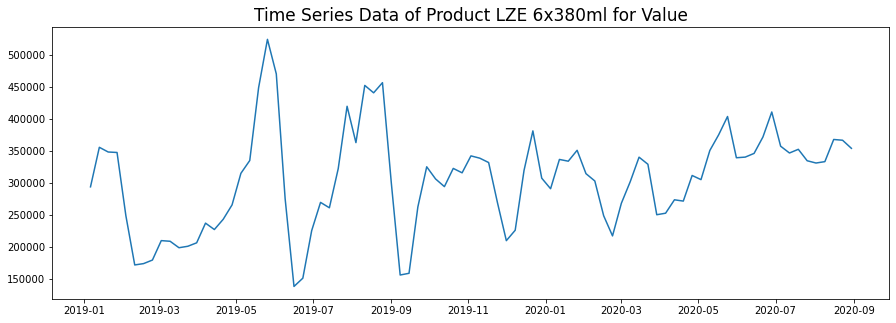

In [95]:
plot(lze6_value,"Time Series Data of Product LZE 6x380ml for Value")

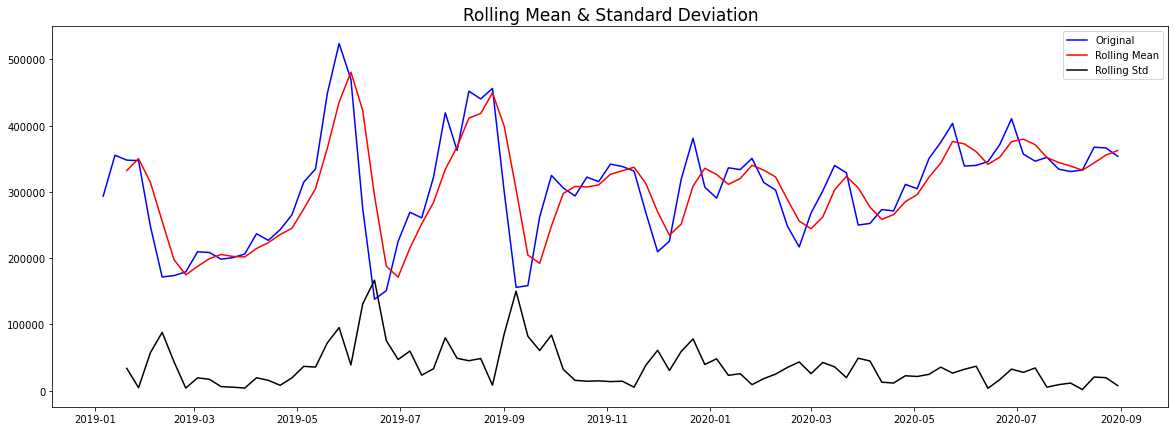

Results of Dickey-Fuller Test:
Test Statistic                 -3.078930
p-value                         0.028152
#Lags Used                     12.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
Critical Value (10%)           -2.588072
dtype: float64


In [96]:
test_stationarity(lze6_value)

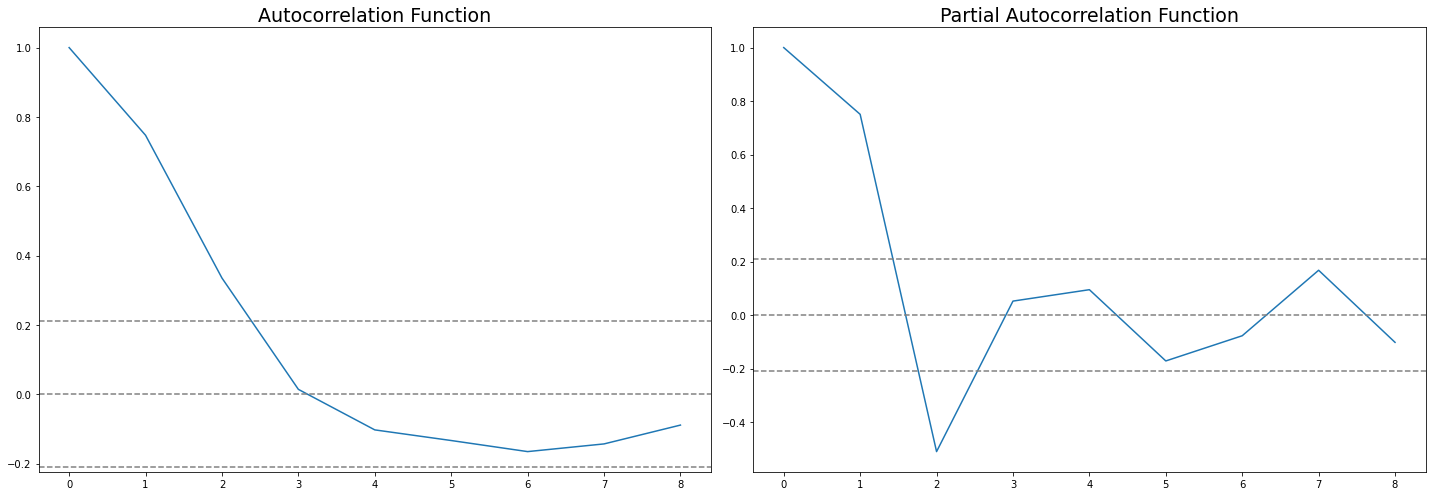

In [97]:
corr(lze6_value)

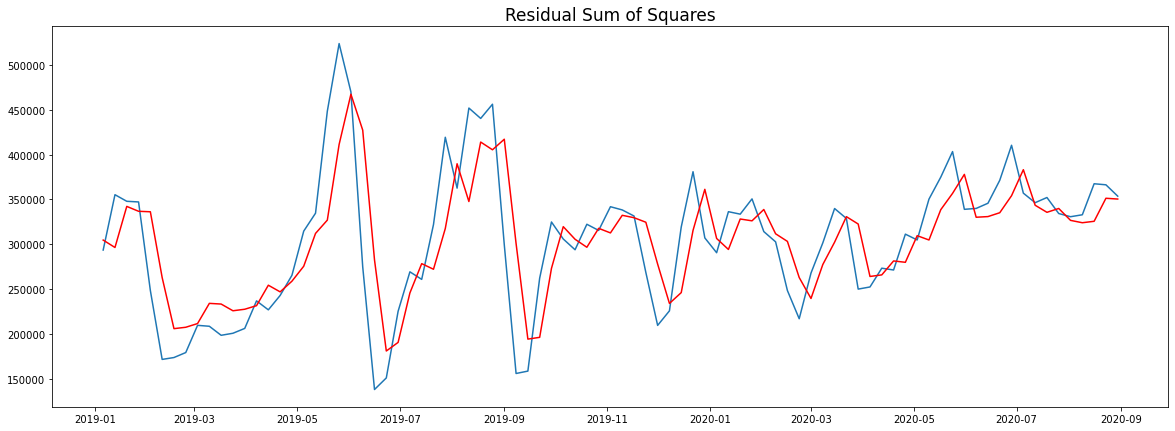

In [98]:
#Plotting the RSS
model = ARIMA(lze6_value,order=(1,0,0))
lzresult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(lze6_value)
plt.plot(lzresult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [99]:
lze6_val_prediction = round(lzresult_ARIMA.predict(1,150),2)
lze6_val_prediction = pd.DataFrame(lze6_val_prediction,columns=['Value']) 
lze6_val_prediction.head()

Value
2019-01-13  296444.87
2019-01-20  342273.71
2019-01-27  336821.97
2019-02-03  336279.51
2019-02-10  262910.45

In [100]:
lze6_value_per = lze6[['Dates','Value%']]
lze6_value_per = lze6_value_per.set_index('Dates')
lze6_value_per = pd.DataFrame(lze6_value_per['Value%'].resample('W').mean())
lze6_value_per.head()

Value%
Dates             
2019-01-06   2.745
2019-01-13   3.320
2019-01-20   3.250
2019-01-27   3.245
2019-02-03   2.320

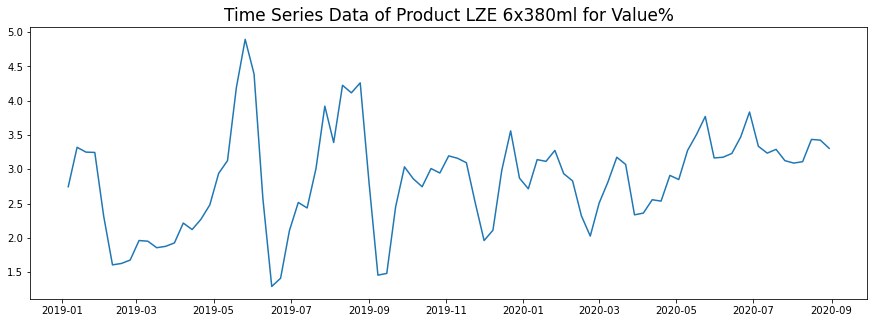

In [101]:
plot(lze6_value_per,"Time Series Data of Product LZE 6x380ml for Value%")

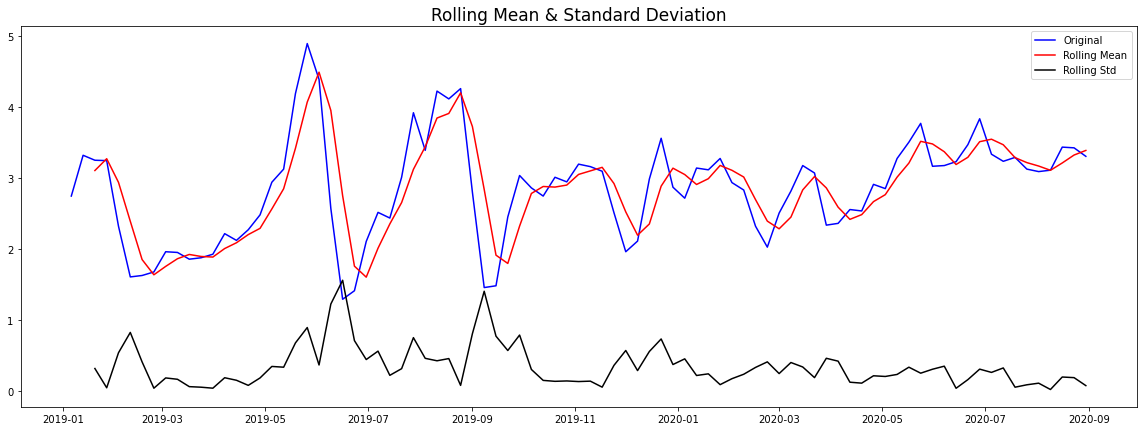

Results of Dickey-Fuller Test:
Test Statistic                 -3.079817
p-value                         0.028083
#Lags Used                     12.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
Critical Value (10%)           -2.588072
dtype: float64


In [102]:
test_stationarity(lze6_value_per)

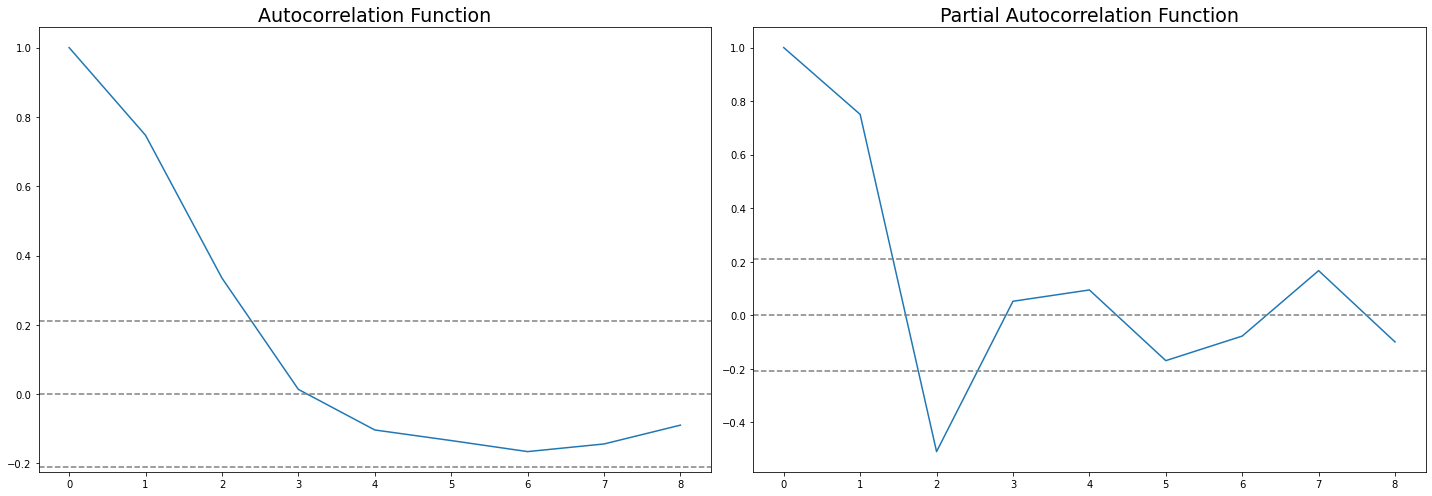

In [103]:
corr(lze6_value_per)

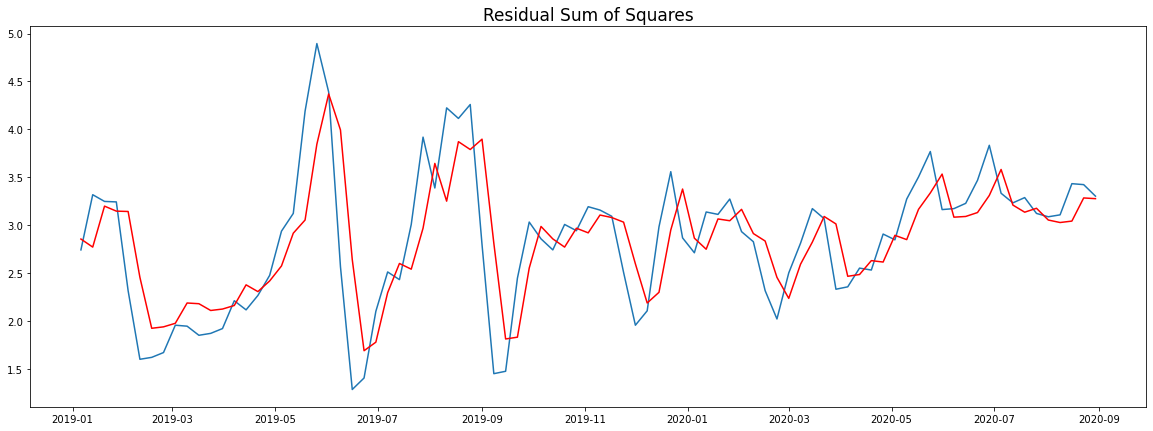

In [104]:
#Plotting the RSS
model = ARIMA(lze6_value_per,order=(1,0,0))
lzpresult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(lze6_value_per)
plt.plot(lzpresult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [105]:
lze6_val_per_prediction = round(lzpresult_ARIMA.predict(1,150),2)
lze6_val_per_prediction = pd.DataFrame(lze6_val_per_prediction,columns=['Value%']) 
lze6_val_per_prediction.head()

Value%
2019-01-13    2.77
2019-01-20    3.20
2019-01-27    3.15
2019-02-03    3.15
2019-02-10    2.46

In [106]:
lze6_lit = lze6[['Dates','Litres']]
lze6_lit = lze6_lit.set_index('Dates')
lze6_lit = pd.DataFrame(lze6_lit['Litres'].resample('W').mean())
lze6_lit.head()

Litres
Dates                
2019-01-06  285525.54
2019-01-13  352835.70
2019-01-20  348216.42
2019-01-27  348860.52
2019-02-03  222652.26

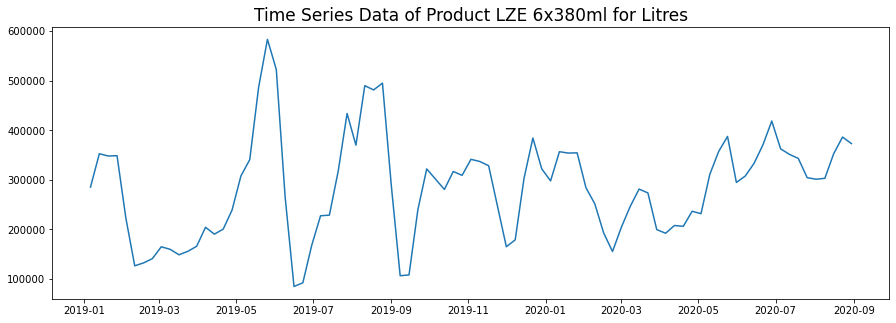

In [107]:
plot(lze6_lit,"Time Series Data of Product LZE 6x380ml for Litres")

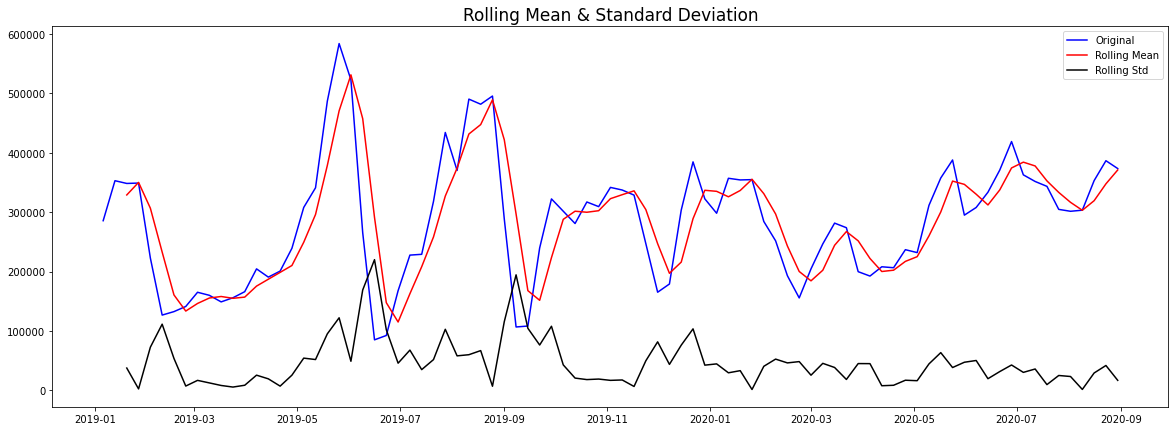

Results of Dickey-Fuller Test:
Test Statistic                 -3.219804
p-value                         0.018867
#Lags Used                     12.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
Critical Value (10%)           -2.588072
dtype: float64


In [108]:
test_stationarity(lze6_lit)

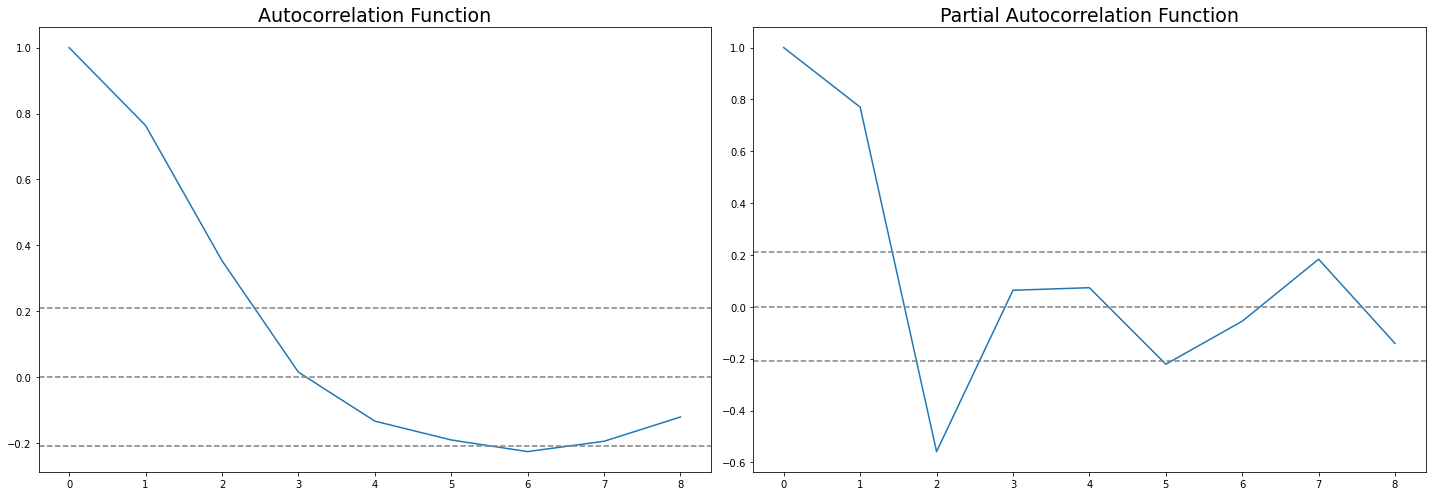

In [109]:
corr(lze6_lit)

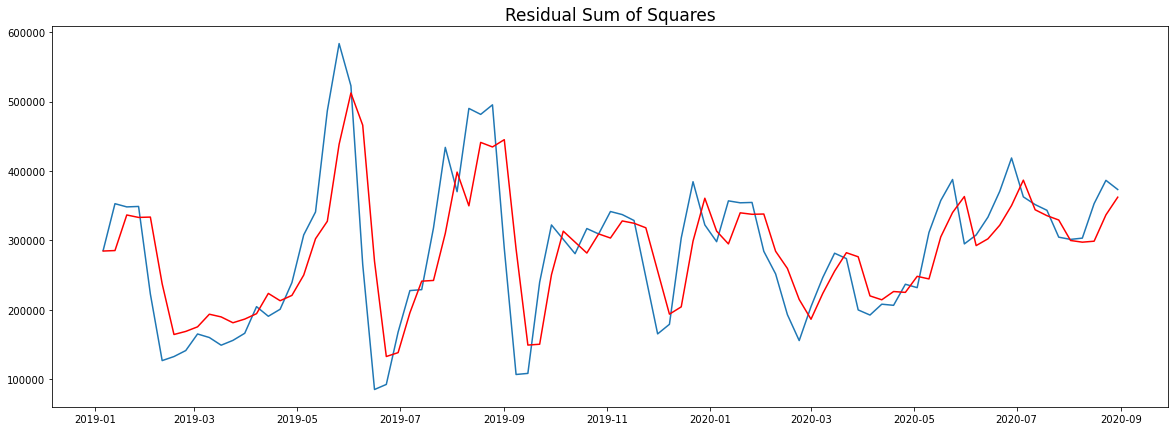

In [110]:
#Plotting the RSS
model = ARIMA(lze6_lit,order=(1,0,0))
lzlresult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(lze6_lit)
plt.plot(lzlresult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [111]:
lze6_lit_prediction = round(lzlresult_ARIMA.predict(1,150),2)
lze6_lit_prediction = pd.DataFrame(lze6_lit_prediction,columns=['Litres'])
lze6_lit_prediction.head()

Litres
2019-01-13  285306.90
2019-01-20  336577.22
2019-01-27  333058.70
2019-02-03  333549.31
2019-02-10  237416.17

In [112]:
lze6_lit_per = lze6[['Dates','Litres%']]
lze6_lit_per = lze6_lit_per.set_index('Dates')
lze6_lit_per = pd.DataFrame(lze6_lit_per['Litres%'].resample('W').mean())
lze6_lit_per.head()

Litres%
Dates              
2019-01-06    3.530
2019-01-13    4.365
2019-01-20    4.305
2019-01-27    4.315
2019-02-03    2.755

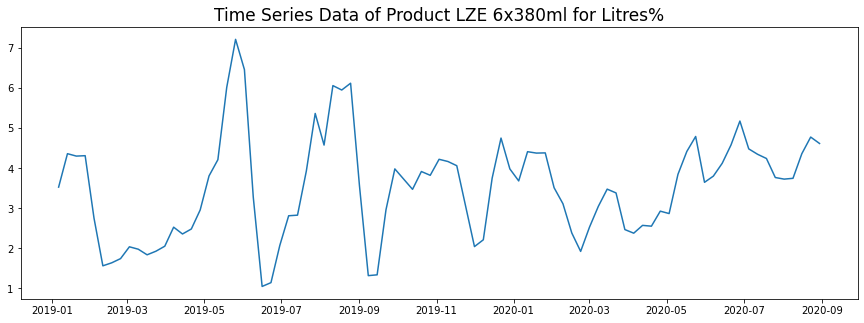

In [113]:
plot(lze6_lit_per,"Time Series Data of Product LZE 6x380ml for Litres%")

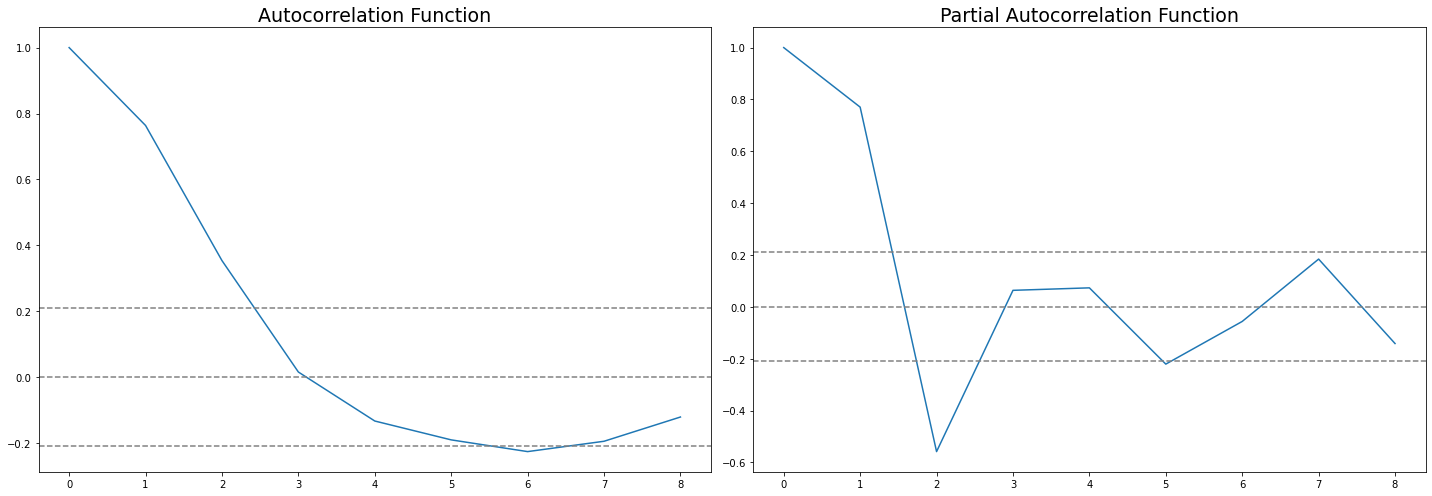

In [114]:
corr(lze6_lit_per)

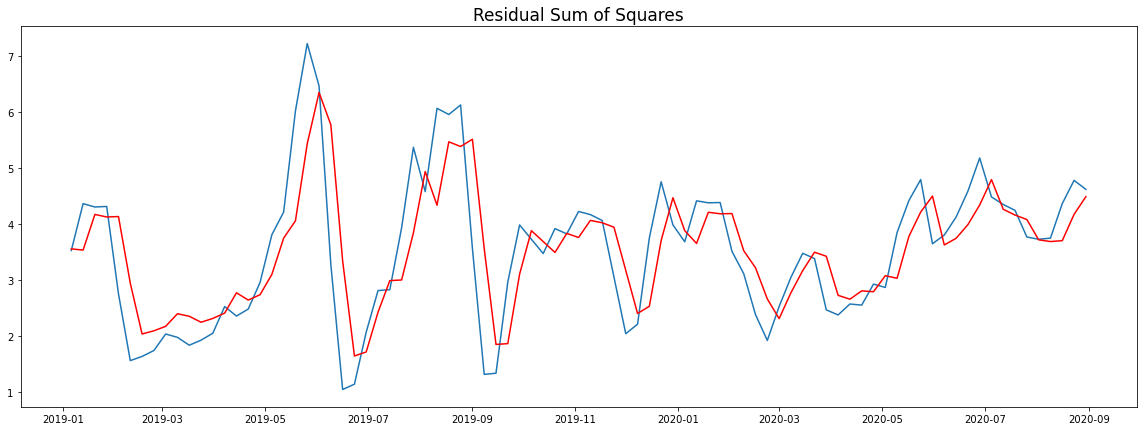

In [115]:
#Plotting the RSS
model = ARIMA(lze6_lit_per,order=(1,0,0))
lzlpresult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(lze6_lit_per)
plt.plot(lzlpresult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [116]:
lze6_lit_per_prediction = round(lzlpresult_ARIMA.predict(1,150),2)
lze6_lit_per_prediction = pd.DataFrame(lze6_lit_per_prediction,columns=['Litres%']) 
lze6_lit_per_prediction.head()

Litres%
2019-01-13     3.54
2019-01-20     4.17
2019-01-27     4.13
2019-02-03     4.13
2019-02-10     2.95

In [117]:
lze6 = pd.concat([lze6_value,lze6_value_per,lze6_lit,lze6_lit_per],axis=1)
lze6['product'] = 'LZE 6x380ml'

# Time Series Forecasting For Product LZE 4x380ml

In [118]:
lze4 = energy2[energy2['Product'] == 'LZE 4x380ml']
lze4_value = lze4[['Dates','Value']]
lze4_value = lze4_value.set_index('Dates')
lze4_value= pd.DataFrame(lze4_value.Value.resample('W').mean())
lze4_value.head()

Value
Dates               
2019-01-06  67944.61
2019-01-13  85106.19
2019-01-20  48181.57
2019-01-27  24712.74
2019-02-03  23663.63

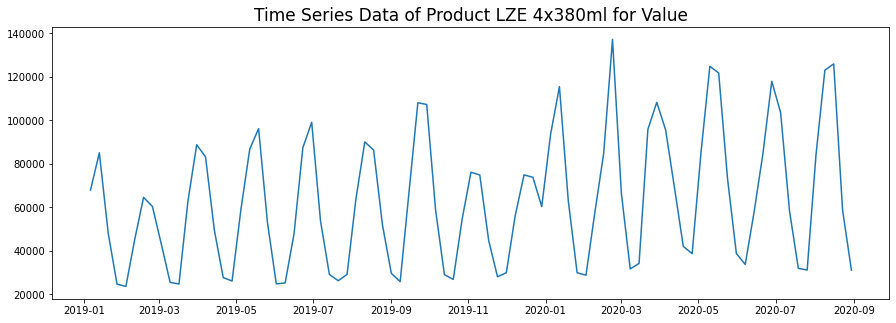

In [119]:
plot(lze4_value,"Time Series Data of Product LZE 4x380ml for Value")

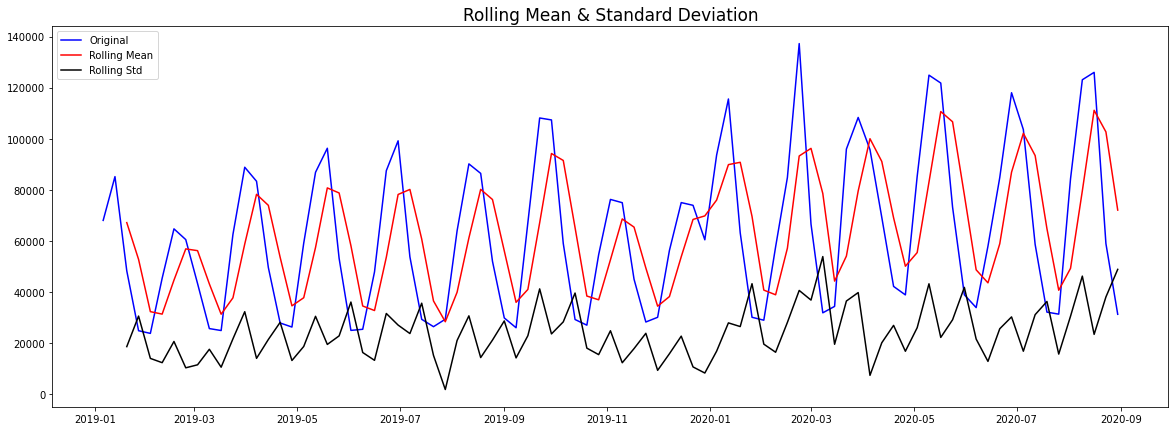

Results of Dickey-Fuller Test:
Test Statistic                 -1.825628
p-value                         0.367814
#Lags Used                      5.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


In [120]:
test_stationarity(lze4_value)

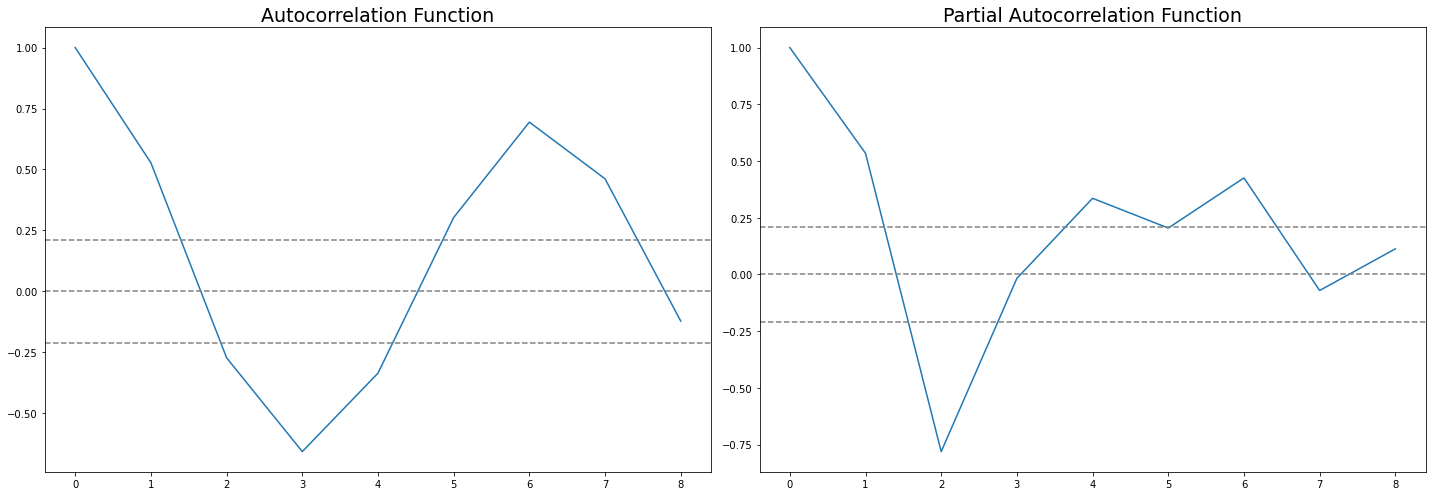

In [121]:
corr(lze4_value)

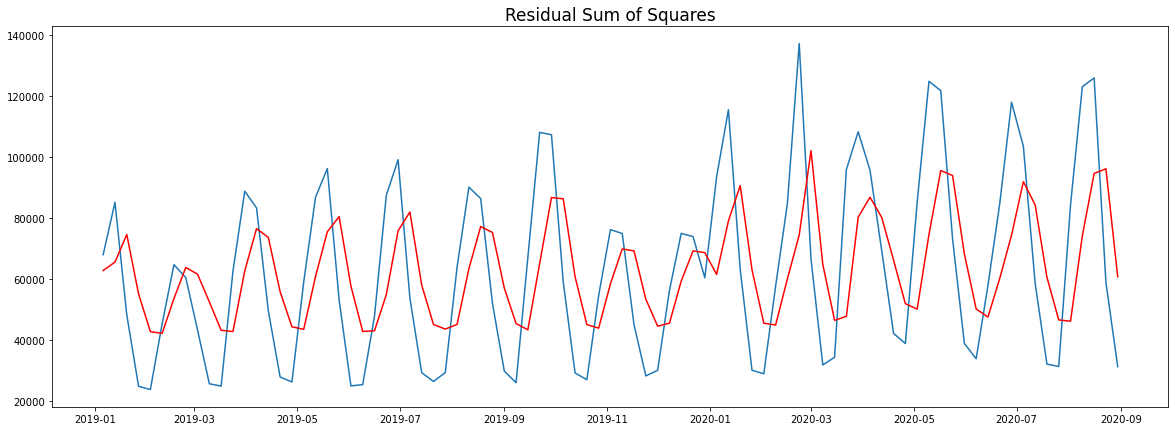

In [122]:
#Plotting the RSS
model = ARIMA(lze4_value,order=(1,0,0))
lz4result_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(lze4_value)
plt.plot(lz4result_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [123]:
lze4_val_prediction = round(lz4result_ARIMA.predict(1,150),2)
lze4_val_prediction = pd.DataFrame(lze4_val_prediction,columns=['Value']) 
lze4_val_prediction.head()

Value
2019-01-13  65488.10
2019-01-20  74551.08
2019-01-27  55051.30
2019-02-03  42657.47
2019-02-10  42103.44

In [124]:
lze4_value_per = lze4[['Dates','Value%']]
lze4_value_per = lze4_value_per.set_index('Dates')
lze4_value_per = pd.DataFrame(lze4_value_per['Value%'].resample('W').mean())
lze4_value_per.head()

Value%
Dates             
2019-01-06    0.63
2019-01-13    0.80
2019-01-20    0.45
2019-01-27    0.23
2019-02-03    0.22

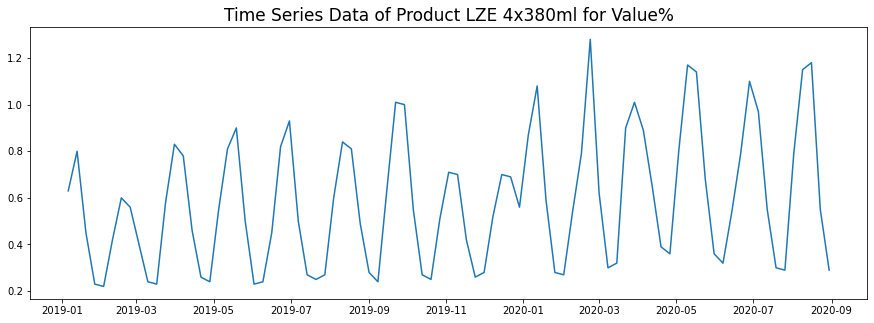

In [125]:
plot(lze4_value_per,"Time Series Data of Product LZE 4x380ml for Value%")

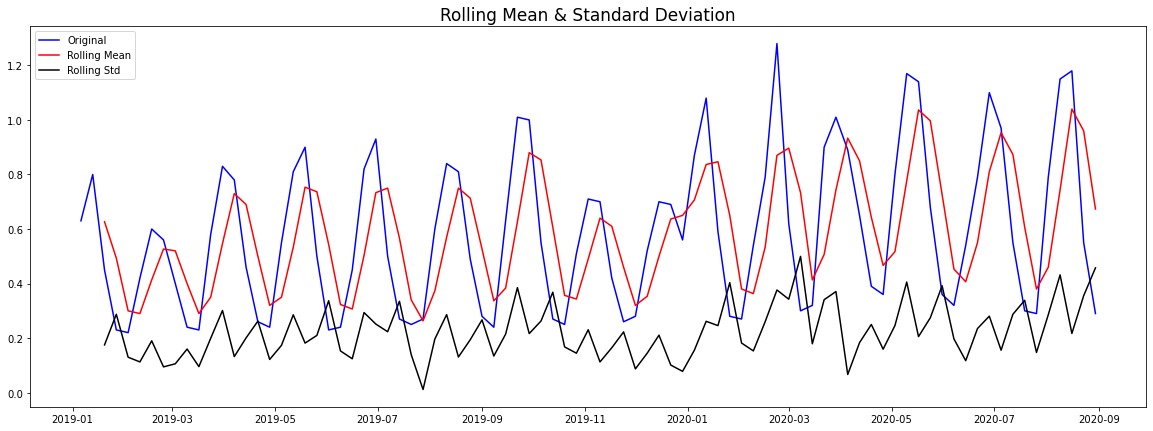

Results of Dickey-Fuller Test:
Test Statistic                 -1.831974
p-value                         0.364707
#Lags Used                      5.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


In [126]:
test_stationarity(lze4_value_per)

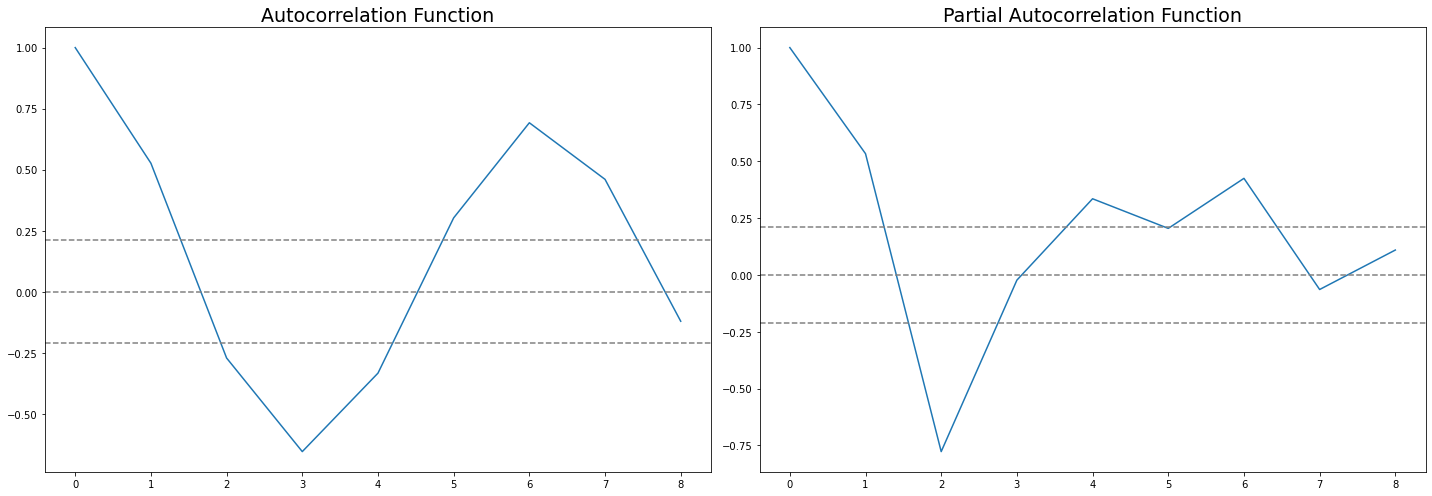

In [127]:
corr(lze4_value_per)

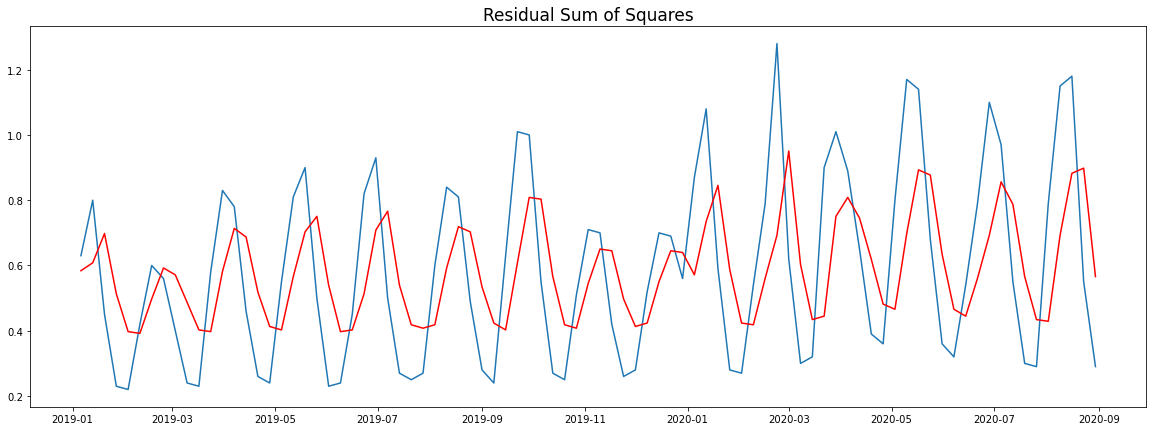

In [128]:
#Plotting the RSS
model = ARIMA(lze4_value_per,order=(1,0,0))
lz4presult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(lze4_value_per)
plt.plot(lz4presult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [129]:
lze4_val_per_prediction = round(lz4presult_ARIMA.predict(1,150),2)
lze4_val_per_prediction = pd.DataFrame(lze4_val_per_prediction,columns=['Value%']) 
lze4_val_per_prediction.head()

Value%
2019-01-13    0.61
2019-01-20    0.70
2019-01-27    0.51
2019-02-03    0.40
2019-02-10    0.39

In [130]:
lze4_lit = lze4[['Dates','Litres']]
lze4_lit = lze4_lit.set_index('Dates')
lze4_lit = pd.DataFrame(lze4_lit['Litres'].resample('W').mean())
lze4_lit.head()

Litres
Dates               
2019-01-06  51660.24
2019-01-13  64744.40
2019-01-20  34806.48
2019-01-27  15801.92
2019-02-03  15133.12

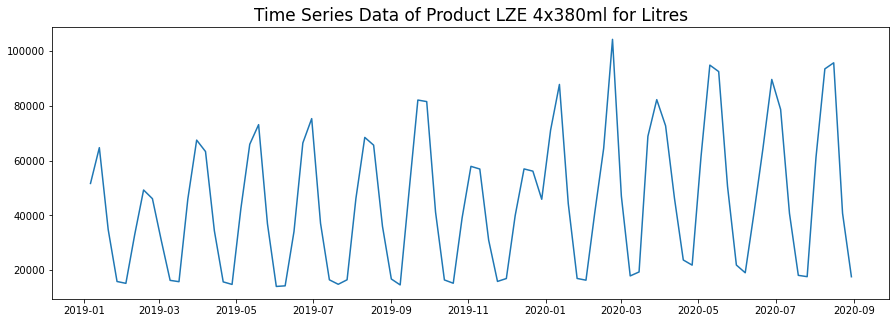

In [131]:
plot(lze4_lit,"Time Series Data of Product LZE 4x380ml for Litres")

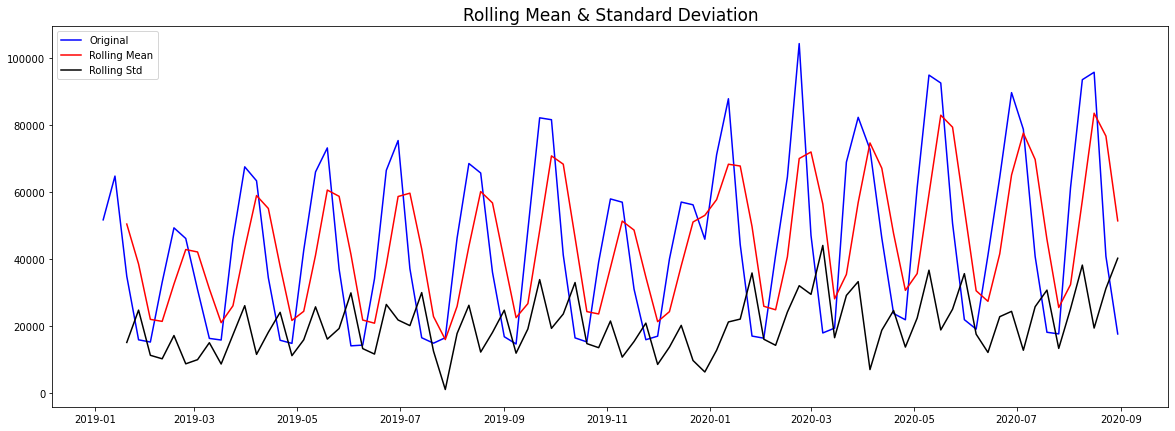

Results of Dickey-Fuller Test:
Test Statistic                 -2.019791
p-value                         0.277964
#Lags Used                      5.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


In [132]:
test_stationarity(lze4_lit)

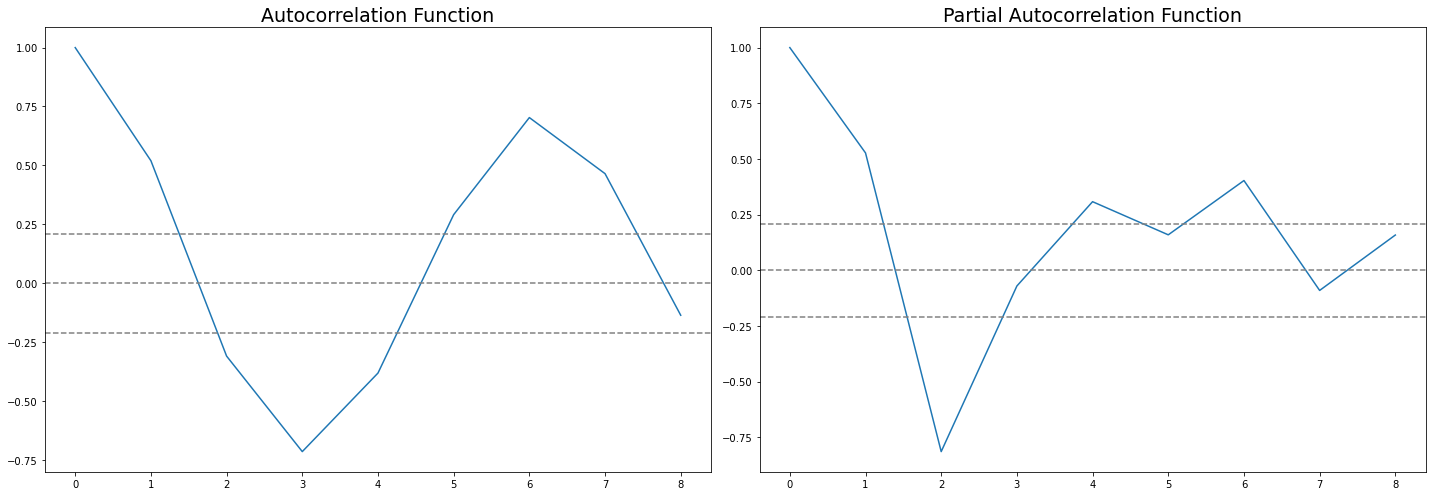

In [133]:
corr(lze4_lit)

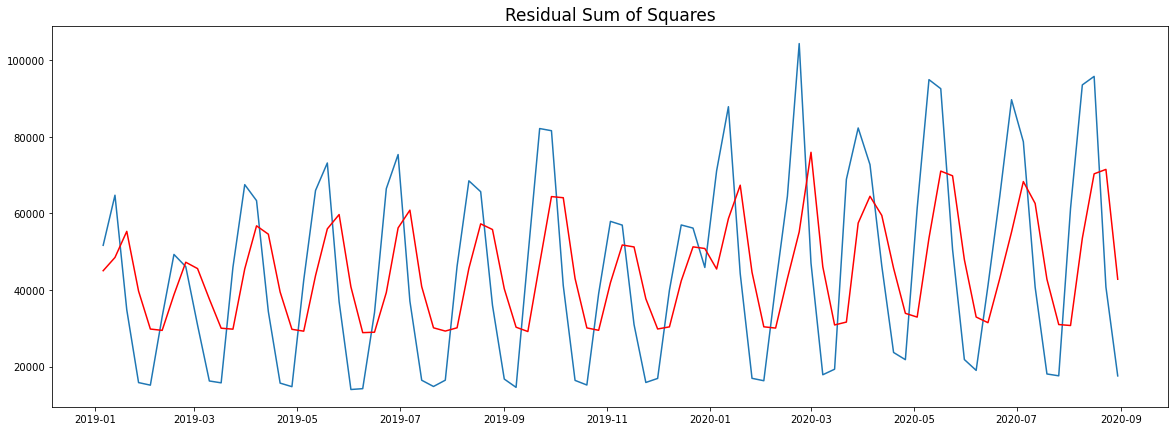

In [134]:
#Plotting the RSS
model = ARIMA(lze4_lit,order=(1,0,0))
lz4lresult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(lze4_lit)
plt.plot(lz4lresult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [135]:
lze4_lit_prediction = round(lz4lresult_ARIMA.predict(1,150),2)
lze4_lit_prediction = pd.DataFrame(lze4_lit_prediction,columns=['Litres']) 
lze4_lit_prediction.head()

Litres
2019-01-13  48484.10
2019-01-20  55305.65
2019-01-27  39697.24
2019-02-03  29789.03
2019-02-10  29440.35

In [136]:
lze4_lit_per = lze4[['Dates','Litres%']]
lze4_lit_per = lze4_lit_per.set_index('Dates')
lze4_lit_per = pd.DataFrame(lze4_lit_per['Litres%'].resample('W').mean())
lze4_lit_per.head()

Litres%
Dates              
2019-01-06     0.64
2019-01-13     0.80
2019-01-20     0.43
2019-01-27     0.20
2019-02-03     0.19

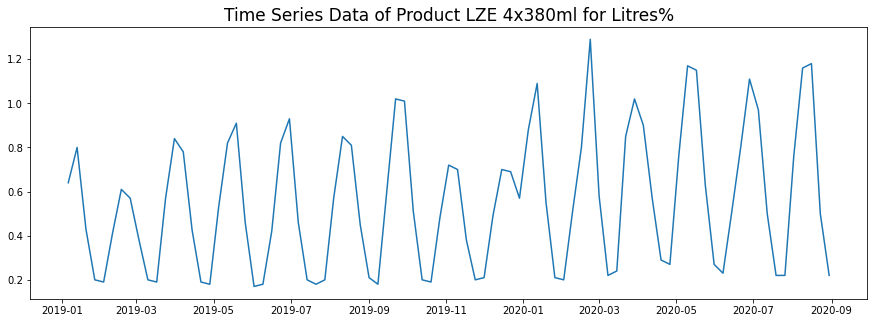

In [137]:
plot(lze4_lit_per,"Time Series Data of Product LZE 4x380ml for Litres%")

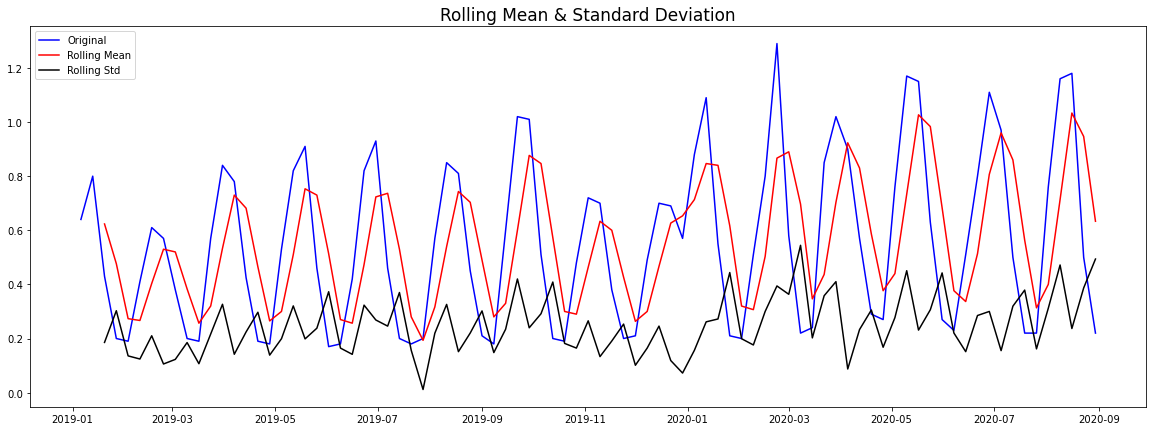

Results of Dickey-Fuller Test:
Test Statistic                 -2.015347
p-value                         0.279885
#Lags Used                      5.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


In [138]:
test_stationarity(lze4_lit_per)

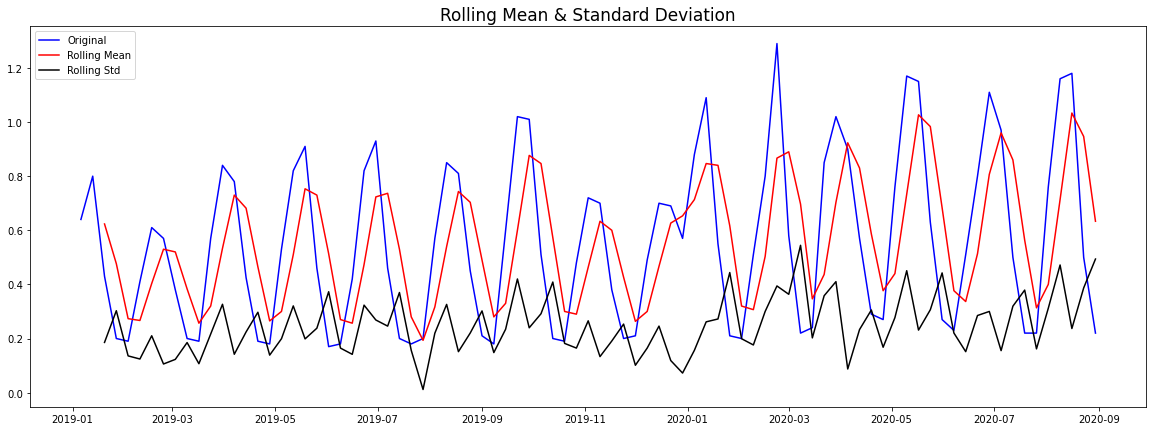

Results of Dickey-Fuller Test:
Test Statistic                 -2.015347
p-value                         0.279885
#Lags Used                      5.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


In [139]:
test_stationarity(lze4_lit_per)

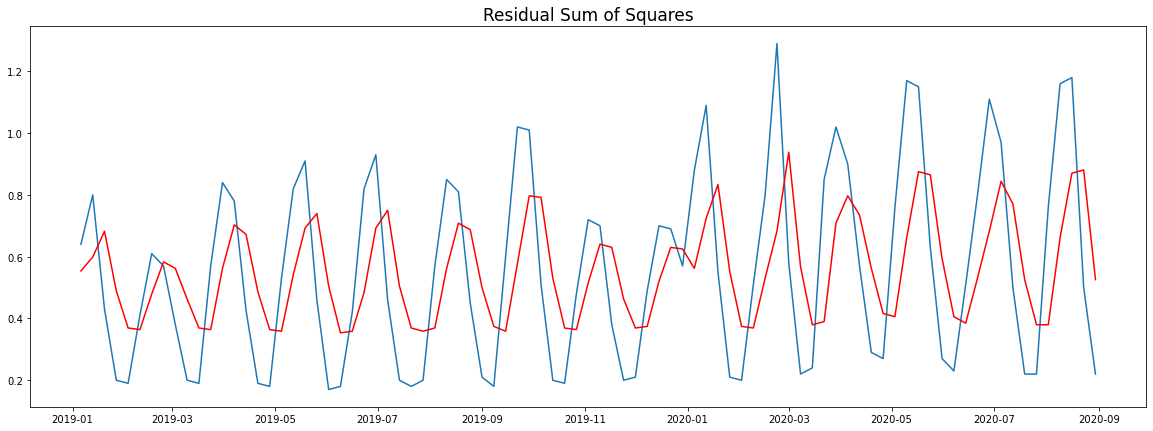

In [140]:
#Plotting the RSS
model = ARIMA(lze4_lit_per,order=(1,0,0))
lz4lpresult_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,7))
plt.plot(lze4_lit_per)
plt.plot(lz4lpresult_ARIMA.fittedvalues,color = 'red')
plt.title('Residual Sum of Squares',fontsize=17)
plt.show()

In [141]:
lze4_lit_per_prediction = round(lz4lpresult_ARIMA.predict(1,150),2)
lze4_lit_per_prediction = pd.DataFrame(lze4_lit_per_prediction,columns=['Litres%']) 
lze4_lit_per_prediction.head()

Litres%
2019-01-13     0.60
2019-01-20     0.68
2019-01-27     0.49
2019-02-03     0.37
2019-02-10     0.36

In [142]:
lze4 = pd.concat([lze4_value,lze4_value_per,lze4_lit,lze4_lit_per],axis=1)
lze4['product'] = 'LZE 4x380ml'

In [143]:
lze4 = lze4.reset_index()
lze6 = lze6.reset_index()
soft_drinks = soft_drinks.reset_index()
everyday = everyday.reset_index()
Lucozade = Lucozade.reset_index()

In [144]:
forecast = pd.concat([lze4,lze6,soft_drinks,everyday,Lucozade])

In [145]:
forecast.sort_values(by='Dates',inplace=True)
forecast.to_csv('TimeSeries_Forecast.csv')
forecast

Dates         Value      Value%        Litres     Litres%  \
0  2019-01-06  6.794461e+04    0.630000  5.166024e+04    0.640000   
0  2019-01-06  2.935754e+05    2.745000  2.855255e+05    3.530000   
0  2019-01-06  2.282290e+07  213.222222  2.346602e+07  290.271111   
0  2019-01-06  8.638966e+05    8.071250  6.434647e+05    7.958750   
0  2019-01-06  7.923555e+05    7.401250  6.150244e+05    7.606250   
..        ...           ...         ...           ...         ...   
86 2020-08-30  2.651748e+07  247.737778  2.609170e+07  322.748889   
86 2020-08-30  3.537034e+05    3.305000  3.732896e+05    4.620000   
86 2020-08-30  9.994746e+05    9.338750  7.662013e+05    9.478750   
86 2020-08-30  3.114969e+04    0.290000  1.754840e+04    0.220000   
86 2020-08-30  9.255809e+05    8.648750  7.376646e+05    9.126250   

                       product  
0                  LZE 4x380ml  
0                  LZE 6x380ml  
0            Total Soft Drinks  
0            Everyday Energy 2  
0   Lucozade Everyday Energy 3  
..                         ...  
86           Total Soft Drinks  
86                 LZE 6x380ml  
86           Everyday Energy 2  
86                 LZE 4x380ml  
86  Lucozade Everyday Energy 3  

[435 rows x 6 columns]